In [ ]:
!pip install catboost
!pip install xgboost
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, LabelEncoder
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)


# Utils

In [ ]:
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove rows with outliers
    df_cleaned = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df_cleaned

In [ ]:
def drop_columns_with_nulls_over_threshold(df, threshold=50.0):
    # Calculate the number of NaNs and the percentage for each column
    col_na = df.isnull().sum()
    percent = (col_na / len(df)) * 100

    # Create a DataFrame with the counts and percentages
    missing_data = pd.concat([col_na, percent], axis=1, keys=['Total', 'Percent'])

    # Find columns where the percentage of NaNs is greater than the threshold
    cols_to_drop = missing_data[missing_data['Percent'] > threshold].index

    # Drop these columns
    df_dropped = df.drop(columns=cols_to_drop)

    # Return the DataFrame with the columns dropped and the list of dropped columns
    return df_dropped, cols_to_drop


In [ ]:
def barplot(df):
    # Calculate the sum of null values in each column and convert to percentage
    total_rows = len(df)
    null_counts = (df.isnull().sum() / total_rows) * 100

    # Generate different colors for each column
    colors = plt.cm.viridis(np.linspace(0, 1, len(null_counts)))

    # Create a horizontal bar plot
    plt.figure(figsize=(20, 20))
    null_counts.sort_values(ascending=True).plot(kind='barh', color=colors)
    plt.title('Percentage of Null Values in df Columns')
    plt.xlabel('Percentage of Null Values')
    plt.ylabel('Columns')
    plt.xticks(fontsize=10)  # Adjust font size here (e.g., fontsize=10)
    plt.xlim(0, 100)  # Set x-axis limit to 0-100 for percentages
    plt.tight_layout()
    plt.show()

In [ ]:
# mengecek nilai null
def check_null(df):
    col_na = df.isnull().sum().sort_values(ascending=False)
    percent = col_na / len(df) * 100

    missing_data = pd.concat([col_na, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data[missing_data['Total'] > 0])


# Load Data

In [ ]:
train_df = pd.read_csv('./EuropeanInvestmentManagement_train.csv')
train_df.drop(['ticker'], axis=1,inplace=True)
test_df_regress = pd.read_csv('./EuropeanInvestmentManagement_test_regress.csv')
test_df_regress.drop(['ticker'], axis=1,inplace=True)
test_df_class = pd.read_csv('./EuropeanInvestmentManagement_test_classification.csv')
test_df_class.drop(['ticker'], axis=1,inplace=True)

In [ ]:
train_df.head()

category dividend_frequency equity_style equity_size  \
0        Global Flex-Cap Equity                NaN        Value       Large   
1             US Mid-Cap Equity           Annually        Blend      Medium   
2  Asia-Pacific ex-Japan Equity           Annually       Growth       Large   
3     US Large-Cap Blend Equity           Annually        Value       Large   
4         Europe Mid-Cap Equity                NaN       Growth      Medium   

   equity_size_score  price_prospective_earnings  price_book_ratio  \
0             248.25                       10.66              1.00   
1             124.69                       23.06              1.97   
2             322.70                       27.99              3.04   
3             229.67                       17.19              1.77   
4             111.36                       12.15              1.01   

   price_sales_ratio  price_cash_flow_ratio  dividend_yield_factor  \
0               0.92                   6.19                   4.13   
1               1.70                  12.07                   1.30   
2               2.71                  10.35                   0.97   
3               0.75                   6.52                   2.73   
4               0.62                   3.54                   2.86   

   long_term_projected_earnings_growth  historical_earnings_growth  \
0                                 8.66                        3.06   
1                                 9.34                       14.30   
2                                16.87                         NaN   
3                                 7.77                        3.17   
4                                10.02                      -14.02   

   sales_growth  cash_flow_growth  book_value_growth   roa    roe   roic  \
0          4.72              0.16               2.75  6.38  14.04  11.80   
1          7.55              8.56               9.59  7.36  14.61  11.33   
2         13.80             21.53              14.76  7.83  16.35  11.62   
3          3.04             -0.32               1.86  4.68  17.51   8.65   
4        -16.23             -6.55              -2.83  1.86   7.77   2.02   

  bond_interest_rate_sensitivity bond_credit_quality  average_coupon_rate  \
0                            NaN                 NaN                  NaN   
1                            NaN                 NaN                  NaN   
2                            NaN                 NaN                  NaN   
3                            NaN                 NaN                  NaN   
4                            NaN                 NaN                  NaN   

   average_credit_quality  modified_duration  effective_maturity  asset_stock  \
0                     NaN                NaN                 NaN        98.55   
1                     NaN                NaN                 NaN        96.81   
2                     NaN                NaN                 NaN        95.92   
3                     NaN                NaN                 NaN        99.98   
4                     NaN                NaN                 NaN       107.14   

   asset_bond  asset_cash  asset_other  sector_basic_materials  \
0        0.00        1.45         0.00                   14.17   
1        0.57        2.63        -0.01                    8.17   
2        0.00        2.21         1.87                    6.35   
3        0.00        0.21        -0.19                    3.01   
4        0.00       -7.14         0.00                   19.94   

   sector_consumer_cyclical  sector_financial_services  sector_real_estate  \
0                      2.35                      18.69                 NaN   
1                     14.42                      18.82                 NaN   
2                     22.32                      10.82                0.44   
3                     14.47                      13.86                1.73   
4                      2.45                      16.94                1.21   

   sector_co

In [ ]:
test_df_regress.head()

category dividend_frequency equity_style  \
0             USD Moderate Allocation          Quarterly        Value   
1                    UK Equity Income           Annually        Value   
2  Sector Equity Industrial Materials                NaN        Blend   
3      Global Emerging Markets Equity           Annually        Blend   
4                        Korea Equity                NaN        Value   

  equity_size  equity_size_score  price_prospective_earnings  \
0       Large             248.99                       13.72   
1       Large             229.55                       15.97   
2       Large             245.54                       16.00   
3       Large             333.92                       16.91   
4       Large             347.82                       11.18   

   price_book_ratio  price_sales_ratio  price_cash_flow_ratio  \
0              1.21               0.92                   3.77   
1              1.27               0.72                   5.66   
2              1.87               1.31                   9.08   
3              2.29               1.64                   7.02   
4              0.99               0.75                   5.26   

   dividend_yield_factor  historical_earnings_growth  sales_growth  \
0                   5.73                       -0.11          1.98   
1                   6.81                        6.71         -0.18   
2                   3.04                       -3.05          3.55   
3                   2.64                        8.01          5.58   
4                   2.17                      -15.74          4.29   

   cash_flow_growth  book_value_growth   roa    roe   roic  \
0              5.80               2.92  6.26  18.74  11.38   
1              8.32               0.17  5.11  18.94  10.40   
2              2.69               4.57  4.67  10.88   7.13   
3              3.23              11.31  9.81  19.67  13.46   
4             -5.44               6.97  4.13   6.61   5.77   

  bond_interest_rate_sensitivity bond_credit_quality  average_coupon_rate  \
0                           High              Medium                 3.52   
1                            NaN                 NaN                  NaN   
2                            NaN                 NaN                  NaN   
3                            NaN                 NaN                  NaN   
4                            NaN                 NaN                  NaN   

   average_credit_quality  modified_duration  effective_maturity  asset_stock  \
0                    11.0                NaN                9.19        51.12   
1                     NaN                NaN                 NaN        98.93   
2                     NaN                NaN                 NaN       100.00   
3                     NaN                NaN                 NaN        97.07   
4                     NaN                NaN                 NaN       100.00   

   asset_bond  asset_cash  asset_other  sector_basic_materials  \
0       37.28       11.10         0.49                    6.62   
1        0.00        0.69         0.38                   10.63   
2        0.00        0.00         0.00                   92.75   
3        0.00        2.92         0.01                    0.01   
4        0.00        0.00         0.00                    7.30   

   sector_consumer_cyclical  sector_financial_services  sector_real_estate  \
0                      9.95                      20.53                2.73   
1                     10.30                      16.26                1.38   
2                      6.18                        NaN                 NaN   
3                      9.40                      26.45                0.00   
4                      8.72                       8.04                 NaN   

   sector_consumer_defensive  sector_healthcare  sector_utilities  \
0                       9.24              10.33              6.87   
1                      16.30              11.95              2.52 

In [ ]:
test_df_class.head()

category dividend_frequency equity_style equity_size  \
0  Global Large-Cap Blend Equity           Annually        Blend       Large   
1        GBP Flexible Allocation           Annually        Blend       Large   
2            Europe ex-UK Equity           Annually        Blend       Large   
3            US Small-Cap Equity                NaN        Value       Small   
4     Property - Indirect Global          Quarterly        Blend      Medium   

   equity_size_score  price_prospective_earnings  price_book_ratio  \
0             268.51                       18.85              2.48   
1             306.01                       22.41              2.35   
2             237.10                       13.28              1.32   
3              32.58                       13.85              1.12   
4             180.89                       25.22              1.38   

   price_sales_ratio  price_cash_flow_ratio  dividend_yield_factor  \
0               1.35                   8.13                   2.48   
1               1.72                   9.87                   2.16   
2               0.94                   3.74                   3.97   
3               0.75                   5.14                   2.78   
4               4.20                   7.11                   3.48   

   long_term_projected_earnings_growth  historical_earnings_growth  \
0                                 8.20                        6.90   
1                                10.00                        6.60   
2                                 8.60                        1.81   
3                                10.77                        5.18   
4                                 7.01                        5.45   

   sales_growth  cash_flow_growth  book_value_growth    roa    roe   roic  \
0          4.74              5.15               6.39  10.05  26.31  16.61   
1          5.46              5.39               6.22   8.33  23.29  13.39   
2          1.83             10.77               1.92   8.47  18.40  15.66   
3          3.46              9.02               5.97   2.26   5.72   4.57   
4          7.40             13.33               7.76   3.85   9.11    NaN   

  bond_interest_rate_sensitivity bond_credit_quality  average_coupon_rate  \
0                            NaN                 NaN                  NaN   
1                           High                High                 2.69   
2                            NaN                 NaN                  NaN   
3                            NaN                 NaN                  NaN   
4                            NaN                 NaN                  NaN   

   average_credit_quality  modified_duration  effective_maturity  asset_stock  \
0                     NaN                NaN                 NaN        99.85   
1                     3.0              14.73               12.46        81.45   
2                     NaN                NaN                 NaN        96.27   
3                     NaN                NaN                 NaN        99.17   
4                     NaN                NaN                 NaN        97.45   

   asset_bond  asset_cash  asset_other  sector_basic_materials  \
0        0.00       -0.98         1.13                    1.15   
1       15.31        3.23         0.01                    8.07   
2        0.00        3.73         0.00                    6.04   
3        0.00        0.83         0.00                    7.44   
4        0.00        2.55         0.00                     NaN   

   sector_consumer_cyclical  sector_financial_services  sector_real_estate  \
0                     11.59                      10.51                2.97   
1                     22.45                      13.90                1.29   
2                      6.70                      13.95                2.20   
3                     18.98                      19.70               11.50   
4                      1.77                        NaN               95.01   

 

# Cleaning data

Mengidentifikasi persentase null value yang tersebar pada data

In [ ]:
check_null(train_df)

                                    Total    Percent
modified_duration                   20692  92.292596
effective_maturity                  20529  91.565566
bond_credit_quality                 20133  89.799286
bond_interest_rate_sensitivity      20133  89.799286
credit_a                            19897  88.746655
credit_bbb                          19897  88.746655
credit_b                            19897  88.746655
credit_below_b                      19897  88.746655
credit_not_rated                    19897  88.746655
credit_bb                           19897  88.746655
credit_aa                           19897  88.746655
credit_aaa                          19897  88.746655
average_credit_quality              19894  88.733274
holdings_n_bonds                    18291  81.583408
average_coupon_rate                 16351  72.930419
fund_trailing_return_10years        12422  55.405888
dividend_frequency                  11985  53.456735
fund_return_2015                     6604  29.

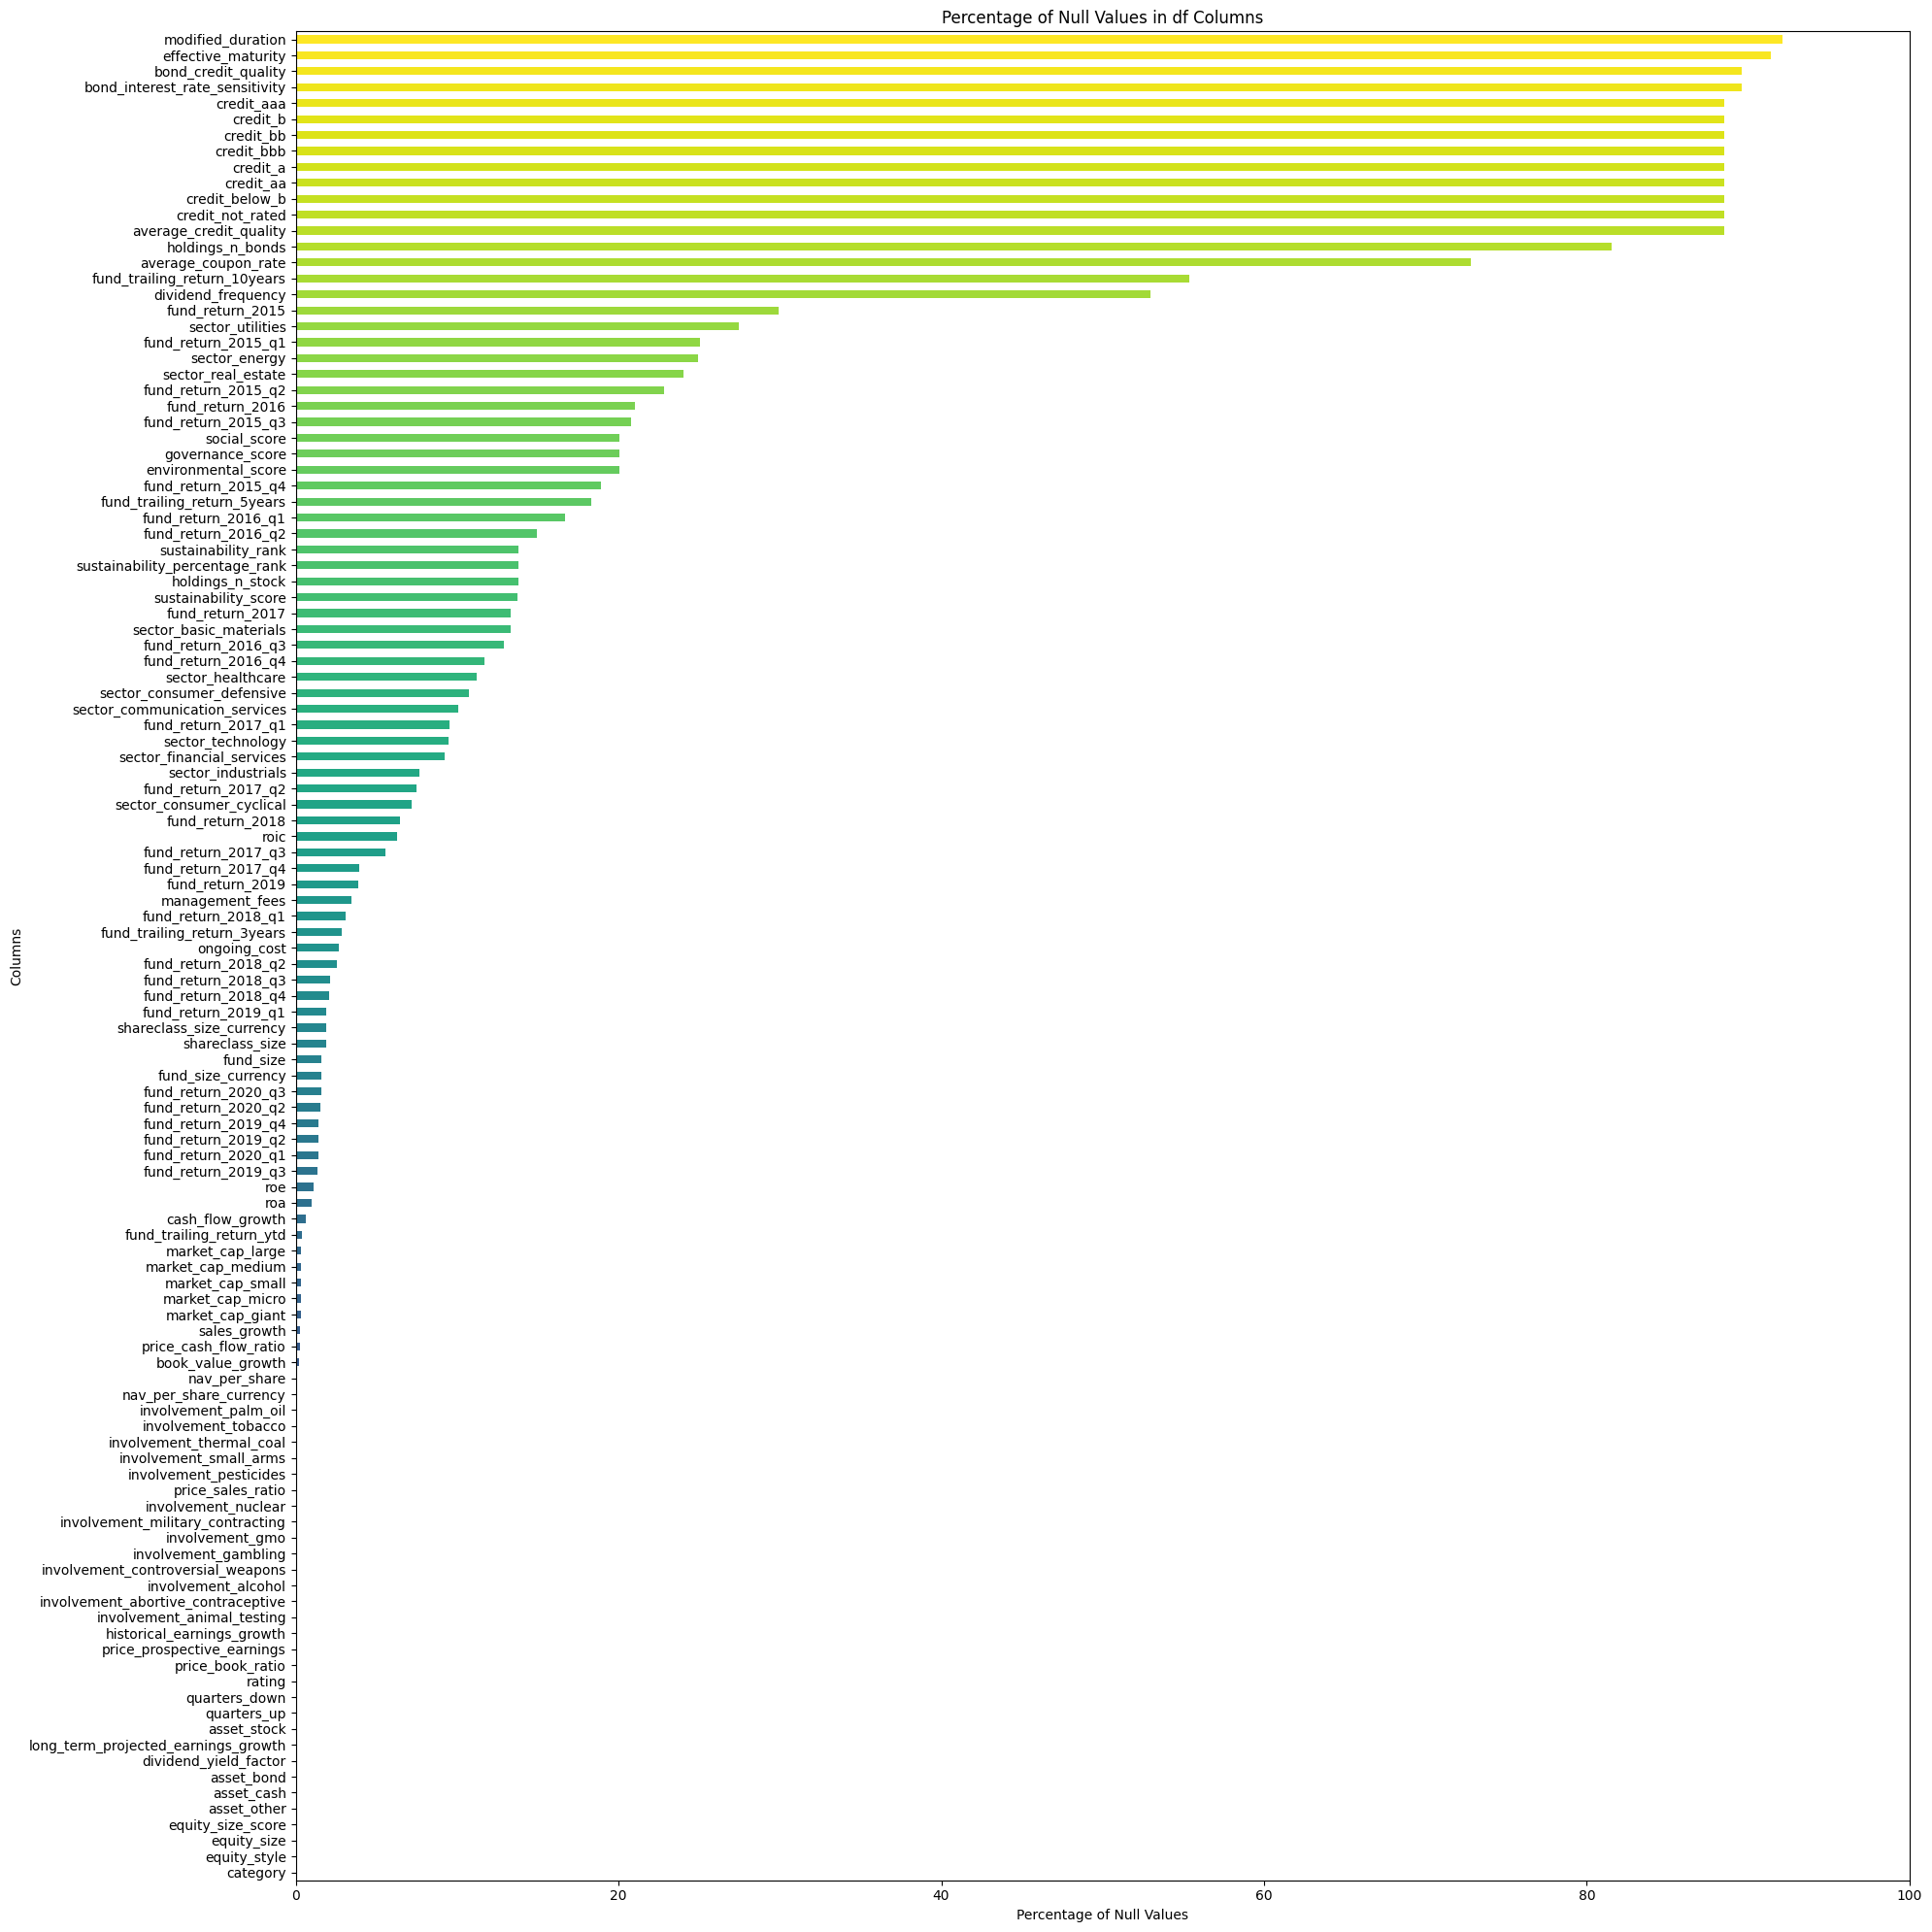

In [ ]:
barplot(train_df)

Terlihat dari barplot di atas bahwa terdapat beberapa kolom yang memiliki banyak sekali null value. Maka kami memutuskan untuk menghapus kolom atau fitur yang memiliki persentase null value di atas 50%

In [ ]:
dropped_train_df, columns_to_drop= drop_columns_with_nulls_over_threshold(train_df) 

In [ ]:
dropped_test_df = test_df_regress.drop(columns=columns_to_drop, axis=True)

In [ ]:
dropped_test_class_df = test_df_class.drop(columns=columns_to_drop, axis=True)


# Exploratory Data Analysis

##  1. Mengetahui 5 besar Investment Management berdasarkan dana kelolaan (fund_size)

In [ ]:
df_sort_fundsize = dropped_train_df.copy()
unique_values = df_sort_fundsize['fund_size_currency'].unique()
unique_values

array(['NOK', 'USD', 'GBP', 'EUR', nan, 'CHF', 'JPY', 'CAD', 'HKD', 'SEK',
       'AUD', 'SGD', 'DKK', 'CNH'], dtype=object)

In [ ]:
#create a dictionary to get conversion rate to USD (data per 27 Aug 2023)
currency_to_usd = {
    'NOK': 0.099 ,
    'USD': 1,
    'GBP': 1.28,
    'EUR': 1.11,
    'CHF': 1.19,
    'JPY': 0.0071,
    'CAD' : 0.76,
    'HKD': 0.13,
    'SEK': 0.10,
    'AUD': 0.68,
    'SGD':0.76,
    'DKK': 0.15,
    'CNH' : 1.4
}

In [ ]:
df_currency = df_sort_fundsize.copy()
df_currency['usd_fund_size'] = None
for index, row in df_currency.iterrows():
    try:
        df_currency.at[index,'usd_fund_size'] = df_currency.at[index,'fund_size'] * currency_to_usd[df_currency.at[index,'fund_size_currency']]
    except:
        continue

In [ ]:
df_fund_sorted = df_currency.sort_values('usd_fund_size', ascending=False)
df_fund_sorted.head()

ticker                           category equity_style equity_size  \
6479   F00000YN9Y  Global Flexible Bond - GBP Hedged        Value      Medium   
17066  F00000OY3N  Global Flexible Bond - USD Hedged        Value      Medium   
10727  F00000SKYP  Global Flexible Bond - CHF Hedged        Value      Medium   
12387  F00000TYLI  Global Flexible Bond - EUR Hedged        Value      Medium   
14056  F00000OZZ4  Global Flexible Bond - USD Hedged        Value      Medium   

       equity_size_score  price_prospective_earnings  price_book_ratio  \
6479              116.43                        9.68               0.3   
17066             116.43                        9.68               0.3   
10727             116.43                        9.68               0.3   
12387             116.43                        9.68               0.3   
14056             116.43                        9.68               0.3   

       price_sales_ratio  price_cash_flow_ratio  dividend_yield_factor  \
6479                1.12                   11.1                    1.9   
17066               1.12                   11.1                    1.9   
10727               1.12                   11.1                    1.9   
12387               1.12                   11.1                    1.9   
14056               1.12                   11.1                    1.9   

       long_term_projected_earnings_growth  historical_earnings_growth  \
6479                                 17.21                      -32.66   
17066                                17.21                      -32.66   
10727                                17.21                      -32.66   
12387                                17.21                      -32.66   
14056                                17.21                      -32.66   

       sales_growth  cash_flow_growth  book_value_growth   roa  roe  roic  \
6479         -18.52              5.87              -6.36 -0.46 -5.6   NaN   
17066        -18.52              5.87              -6.36 -0.46 -5.6   NaN   
10727        -18.52              5.87              -6.36 -0.46 -5.6   NaN   
12387        -18.52              5.87              -6.36 -0.46 -5.6   NaN   
14056        -18.52              5.87              -6.36 -0.46 -5.6   NaN   

       asset_stock  asset_bond  asset_cash  asset_other  \
6479          0.85      122.73      -30.35         6.79   
17066         0.85      122.73      -30.35         6.79   
10727         0.85      122.73      -30.35         6.79   
12387         0.85      122.73      -30.35         6.79   
14056         0.85      122.73      -30.35         6.79   

       sector_basic_materials  sector_consumer_cyclical  \
6479                      NaN                     25.29   
17066                     NaN                     25.29   
10727                     NaN                     25.29   
12387                     NaN                     25.29   
14056                     NaN                     25.29   

       sector_financial_services  sector_real_estate  \
6479                        40.3               25.47   
17066                       40.3               25.47   
10727                       40.3               25.47   
12387                       40.3               25.47   
14056                       40.3               25.47   

       sector_consumer_defensive  sector_healthcare  sector_utilities  \
6479                         NaN                NaN              0.12   
17066                        NaN                NaN              0.12   
10727                        NaN                NaN              0.12   
12387                        NaN                NaN              0.12   
14056                        NaN                NaN              0.12   

       sector_communication_services  sector_energy  sector_industrials  \
6479                             8.8           0.02                 NaN   
17066                            8.8           0.02                 NaN   
10727          

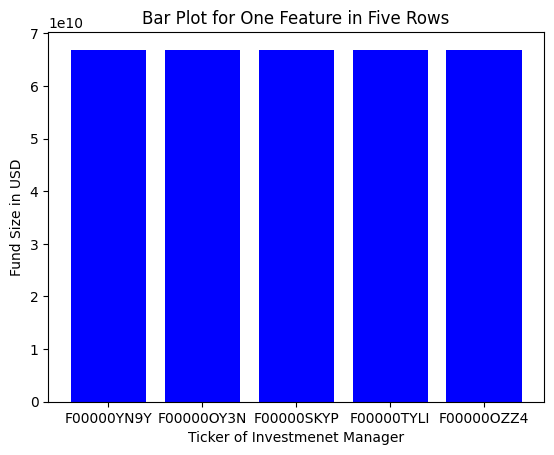

In [ ]:
# Plotting the bar plot for one feature
df_top_five = df_fund_sorted.head()
plt.bar(df_top_five['ticker'], df_top_five['usd_fund_size'], color='blue')

# Adding labels and title
plt.xlabel('Ticker of Investmenet Manager')
plt.ylabel('Fund Size in USD')
plt.title('Bar Plot for One Feature in Five Rows')

# Show the plot
plt.show()

## 2. Mengetahui perbandingan untuk tiap sektor (sector_*)

In [ ]:
sectors = [ 'sector_basic_materials', 'sector_consumer_cyclical', 'sector_financial_services',
           'sector_real_estate', 'sector_consumer_defensive', 'sector_healthcare', 'sector_utilities',
           'sector_communication_services', 'sector_energy', 'sector_industrials', 'sector_technology']
sector_data = dropped_train_df[sectors]
columns_to_exclude = ['rating', 'long_term_projected_earnings_growth']
columns_to_scale = [col for col in sector_data.columns if col not in columns_to_exclude]
data_to_scale = dropped_train_df[columns_to_scale]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_scale)

scaled_df = pd.DataFrame(scaled_data, columns = columns_to_scale)
scaled_df.index = dropped_train_df.index

scaled_df[columns_to_exclude]= dropped_train_df[columns_to_exclude]

scaled_df.head()



sector_basic_materials  sector_consumer_cyclical  \
3                -0.888843                  0.557871   
6                -0.593431                  1.486584   
11               -0.685445                 -0.162977   
14                0.084564                 -0.389911   
16                0.212899                 -0.801825   

    sector_financial_services  sector_real_estate  sector_consumer_defensive  \
3                   -0.369489           -0.503652                   0.463708   
6                   -0.694902            0.035832                  -0.317688   
11                  -0.374346           -0.931759                  -0.315621   
14                  -0.511958           -0.472327                  -0.437585   
16                   0.584084            1.699530                  -1.626217   

    sector_healthcare  sector_utilities  sector_communication_services  \
3           -0.085517         -0.781488                      -0.140896   
6           -1.191380         -1.097521                       0.964371   
11           0.371366         -0.996807                       0.775839   
14           0.471742         -1.010699                       1.367357   
16          -1.442319          0.270800                       0.115978   

    sector_energy  sector_industrials  sector_technology  rating  \
3       -0.149348            0.992813           0.098467     2.0   
6       -0.341685           -1.062723           1.650718     3.0   
11      -0.428931           -0.521697           1.502490     3.0   
14      -0.323839           -0.543411           0.871628     3.0   
16      -0.512211           -1.500610           2.447596     3.0   

    long_term_projected_earnings_growth  
3                                  7.77  
6                                 12.29  
11                                 9.91  
14                                 8.78  
16                                 7.05

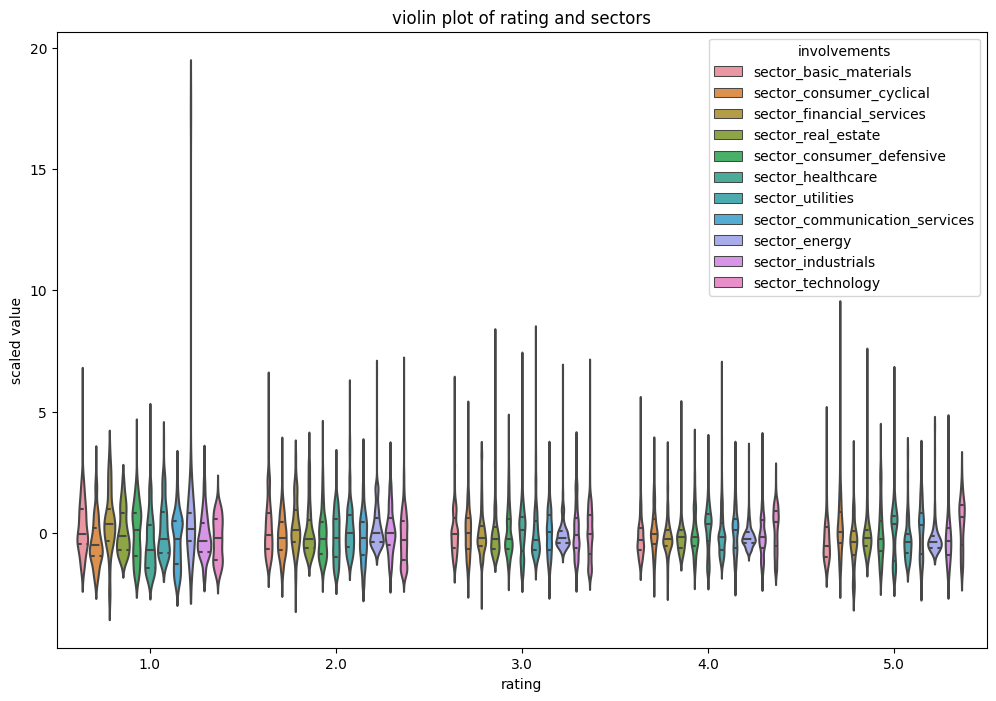

In [ ]:
columns_to_include =[ 'sector_basic_materials', 'sector_consumer_cyclical', 'sector_financial_services',
           'sector_real_estate', 'sector_consumer_defensive', 'sector_healthcare', 'sector_utilities',
           'sector_communication_services', 'sector_energy', 'sector_industrials', 'sector_technology', 'rating']


plot_data = scaled_df[columns_to_include]
# num_rows_to_sample = 200

# # Randomly sample rows from the DataFrame
# plot_data = plot_data.sample(n=num_rows_to_sample, random_state=42)  # Set a random seed for reproducibility


plt.figure(figsize=(12,8))
sns.violinplot(x='rating', y='value', hue='variable', data=plot_data.melt('rating'),inner='quart')
plt.title('violin plot of rating and sectors')
plt.xlabel('rating')
plt.ylabel('scaled value')
plt.legend(title='involvements')
plt.show()

## 3. Hubungan Management_fees dengan return investasi


Correlation: 0.02855912894997523


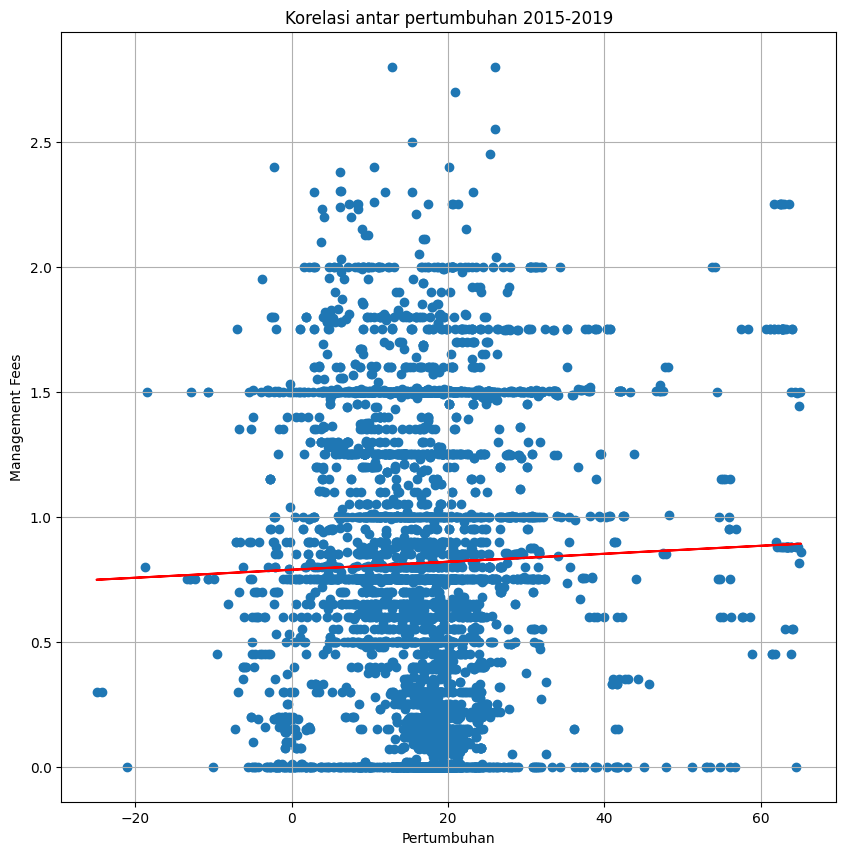

In [ ]:
growth = (dropped_train_df['fund_return_2019'] - dropped_train_df['fund_return_2015'])
print(f'Correlation: {growth.corr(dropped_train_df["management_fees"])}')

m, b = np.polyfit(growth, dropped_train_df['management_fees'], 1)

plt.figure(figsize=(10, 10))
plt.scatter(growth, dropped_train_df['management_fees'])
plt.plot(growth, m * growth + b, color='red', label='Fit Line')
plt.title('Korelasi antar pertumbuhan 2015-2019')
plt.xlabel('Pertumbuhan')
plt.ylabel('Management Fees')
plt.grid(True)
plt.show()


## 4. Perbedaan Equity Style

In [ ]:
financial_metrics = []
for column in dropped_train_df.columns:
    if column[:5] == "price":
        financial_metrics.append(column)

financial_metrics

['price_prospective_earnings',
 'price_book_ratio',
 'price_sales_ratio',
 'price_cash_flow_ratio']

In [ ]:
financial_metrics.append("equity_style")

In [ ]:
financial_df = dropped_train_df[financial_metrics]
financial_df.head()

price_prospective_earnings  price_book_ratio  price_sales_ratio  \
3                        17.19              1.77               0.75   
6                        16.16              1.77               1.45   
11                       24.06              2.95               2.63   
14                       21.12              3.33               2.65   
16                       15.45              1.42               1.06   

    price_cash_flow_ratio equity_style  
3                    6.52        Value  
6                    3.86        Blend  
11                  12.38        Blend  
14                  14.49        Blend  
16                   5.27        Value

In [ ]:
sector_data = financial_df[financial_metrics]
columns_to_exclude = ["equity_style"]

columns_to_scale = [col for col in sector_data.columns if col not in columns_to_exclude]

data_to_scale = dropped_train_df[columns_to_scale]

# Create a StandardScaler
financialScaler = StandardScaler()

# Fit and transform the data using the scaler
financial_scaled_data = financialScaler.fit_transform(data_to_scale)

# Create a DataFrame with the scaled values and the same column names
financial_scaled_df = pd.DataFrame(financial_scaled_data, columns=columns_to_scale)
financial_scaled_df.index = financial_df.index

# Add back the columns that were excluded from scaling
financial_scaled_df[columns_to_exclude] = financial_df[columns_to_exclude]

# Display the scaled DataFrame
financial_scaled_df.head()


price_prospective_earnings  price_book_ratio  price_sales_ratio  \
3                    -0.022524         -0.149573          -1.066933   
6                    -0.260925         -0.149573           0.015759   
11                    1.567586          1.342053           1.840869   
14                    0.887102          1.822407           1.871803   
16                   -0.425259         -0.592004          -0.587455   

    price_cash_flow_ratio equity_style  
3               -0.543294        Value  
6               -1.359157        Blend  
11               1.254057        Blend  
14               1.901227        Blend  
16              -0.926688        Value

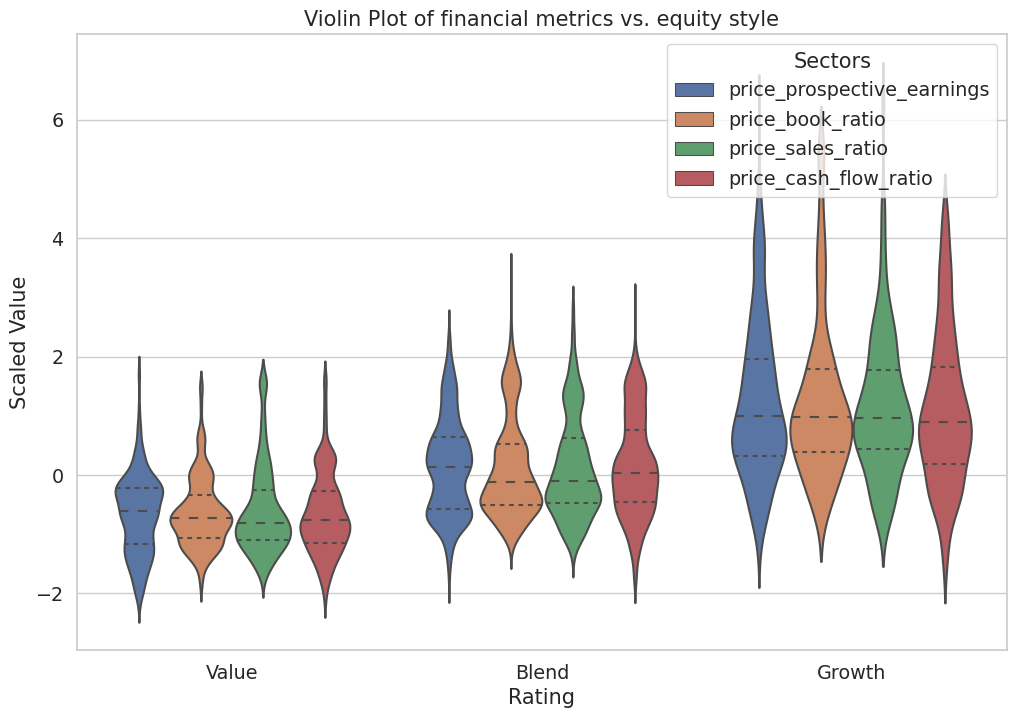

In [ ]:
sns.set(style="whitegrid", font_scale=1.25)


# Define the columns you want to include in the violin plot
columns_to_include = ["price_prospective_earnings",	"price_book_ratio",	"price_sales_ratio","price_cash_flow_ratio", "equity_style"]

# Create a new DataFrame with the selected columns
plot_data = financial_scaled_df[columns_to_include]

# Create a violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x="equity_style", y="value", hue="variable", data=plot_data.melt("equity_style"), inner="quart")
plt.title("Violin Plot of financial metrics vs. equity style")
plt.xlabel("Rating")
plt.ylabel("Scaled Value")
plt.legend(title="Sectors")
plt.show()

## 5. Mencari hubungan keterlibatan pada bisnis produce yang kontroversial dengan rating

In [ ]:
columns_to_scale = ['involvement_abortive_contraceptive', 'involvement_alcohol','involvement_animal_testing','involvement_controversial_weapons', 'involvement_gambling',
                     'involvement_gmo','involvement_military_contracting', 'involvement_nuclear', 'involvement_palm_oil', 'involvement_pesticides', 'involvement_small_arms',
                     'involvement_thermal_coal', 'involvement_tobacco']
columns_to_ex = [col for col in dropped_train_df.columns if col not in columns_to_scale ]

data_to_scale = dropped_train_df[columns_to_scale]
scaler= StandardScaler()

scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns = columns_to_scale)
scaled_df.index = dropped_train_df.index
scaled_df[columns_to_ex] = dropped_train_df[columns_to_ex]
scaled_df.head()

involvement_abortive_contraceptive  involvement_alcohol  \
3                             0.098557            -0.758907   
6                            -1.450248            -0.372235   
11                           -0.158524            -0.824260   
14                            1.091056            -0.824260   
16                           -1.450248            -0.824260   

    involvement_animal_testing  involvement_controversial_weapons  \
3                    -0.306052                           0.542224   
6                    -1.230702                          -0.717786   
11                   -0.136651                           1.032228   
14                    0.356429                           1.137229   
16                   -1.347670                           0.857226   

    involvement_gambling  involvement_gmo  involvement_military_contracting  \
3              -0.266167         0.141258                          0.988730   
6              -0.567543        -0.191128                         -0.379365   
11             -0.567543         4.351481                          0.469117   
14             -0.567543        -0.191128                          0.548046   
16              6.859903        -0.191128                         -0.846359   

    involvement_nuclear  involvement_palm_oil  involvement_pesticides  \
3             -0.270876             -0.236799               -0.259277   
6             -0.780941             -0.236799               -0.473457   
11            -0.780941             -0.236799                1.693542   
14            -0.621546             -0.236799               -0.473457   
16            -0.780941             -0.236799               -0.473457   

    involvement_small_arms  involvement_thermal_coal  involvement_tobacco  \
3                -0.175952                 -0.584096            -0.287564   
6                 0.179691                 -1.006119             0.992512   
11                0.440496                 -0.628781             0.174376   
14               -0.661998                 -1.006119            -0.632628   
16               -0.661998                  0.960013            -0.632628   

        ticker                             category equity_style equity_size  \
3   F000005K32            US Large-Cap Blend Equity        Value       Large   
6   F000000LIL                 Asia ex-Japan Equity        Blend       Large   
11  F00000N6ZP            US Large-Cap Blend Equity        Blend       Large   
14  F00000MJKD            US Large-Cap Blend Equity        Blend       Large   
16  F0GBR0550U  Asia-Pacific ex-Japan Equity Income        Value       Large   

    equity_size_score  price_prospective_earnings  price_book_ratio  \
3              229.67                       17.19              1.77   
6              369.24                       16.16              1.77   
11             309.51                       24.06              2.95   
14             326.65                       21.12              3.33   
16             325.58                       15.45              1.42   

    price_sales_ratio  price_cash_flow_ratio  dividend_yield_factor  \
3                0.75                   6.52                   2.73   
6                1.45                   3.86                   2.91   
11               2.63                  12.38                   1.58   
14               2.65                  14.49                   1.85   
16               1.06                   5.27                   4.22   

    long_term_projected_earnings_growth  historical_earnings_growth  \
3                                  7.77                        3.17   
6                                 12.29                        9.37   
11                                 9.91                       16.04   
14                                 8.78                       17.27   
16                                 7.05                       -1.60   

    sales_growth  cash_flow_growth  book_value_growth   roa    roe   ro

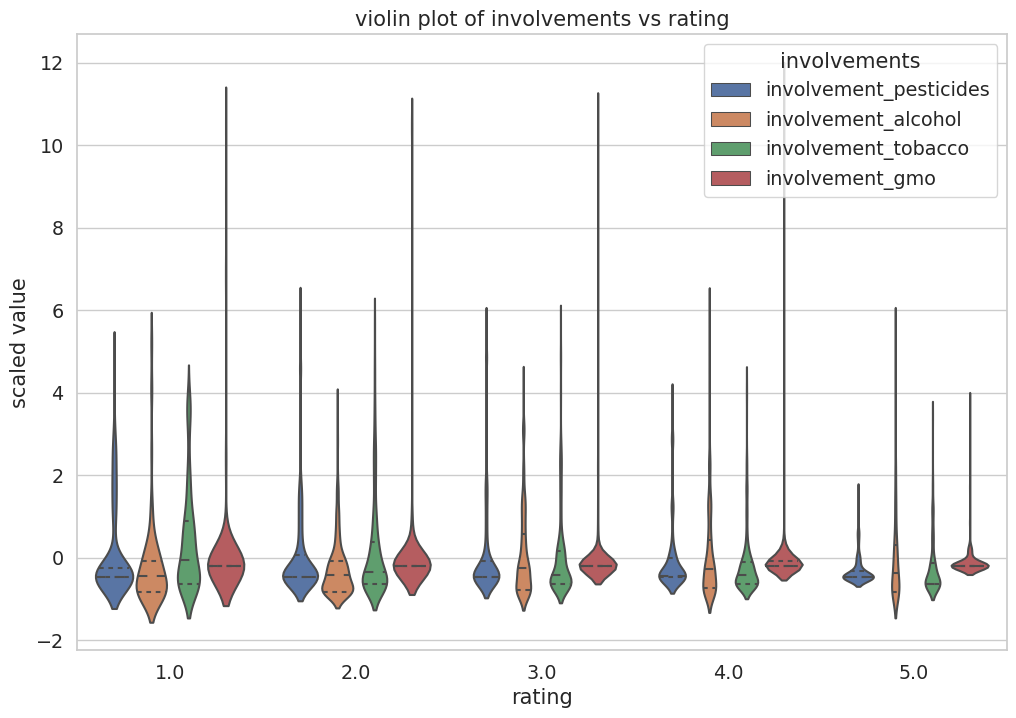

In [ ]:
columns_to_include = ['involvement_pesticides', 'involvement_alcohol',
                      'involvement_tobacco', 'involvement_gmo', 'rating']

plot_data = scaled_df[columns_to_include]

plt.figure(figsize=(12,8))
sns.violinplot(x='rating', y='value', hue='variable', data=plot_data.melt('rating'),inner='quart')
plt.title('violin plot of involvements vs rating')
plt.xlabel('rating')
plt.ylabel('scaled value')
plt.legend(title='involvements')
plt.show()

## 6. Hubungan involvement pada bisnis senjata dan return on investment rate

In [ ]:
# Get the mean and median of the column
mean_value = dropped_train_df['roic'].mean()
median_value = dropped_train_df['roic'].median()
print(f'the mean and media for roic is {mean_value} and {median_value}')

the mean and media for roic is 10.766092402464064 and 11.03


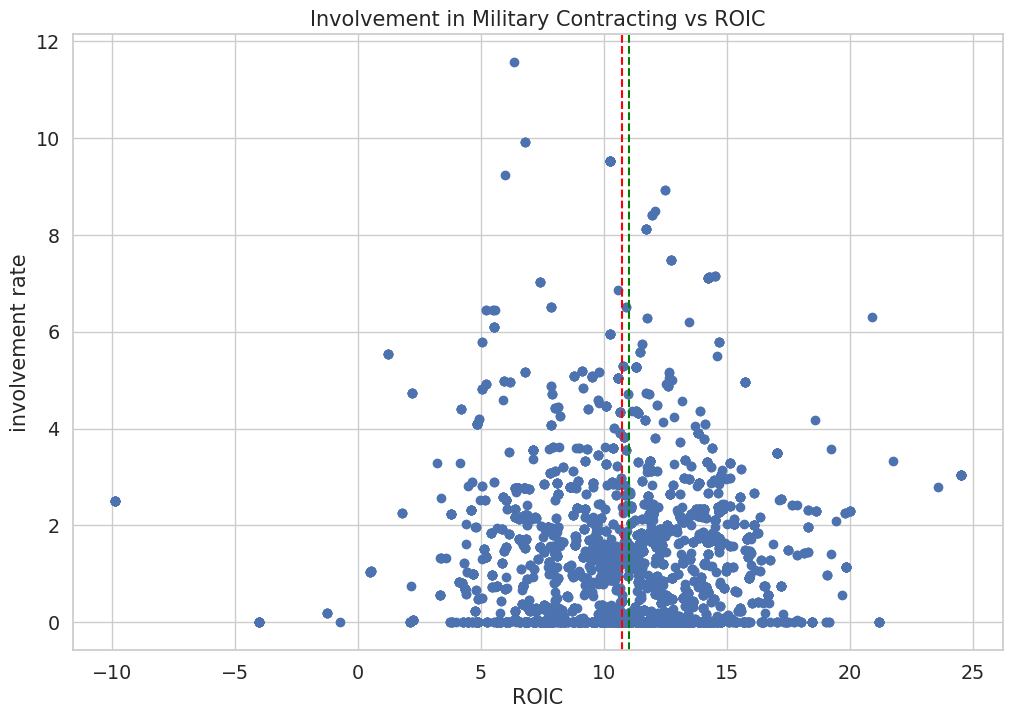

In [ ]:
# Add labels and a title
plt.figure(figsize=(12,8))
plt.scatter(dropped_train_df['roic'], dropped_train_df['involvement_military_contracting'], label='Scatter Plot')

plt.title('Involvement in Military Contracting vs ROIC')
plt.xlabel('ROIC')
plt.ylabel('involvement rate')
plt.axvline(x=mean_value, color='red', linestyle='--', label='roic mean')
plt.axvline(x=median_value, color='green', linestyle='--', label='roic median')
plt.show()

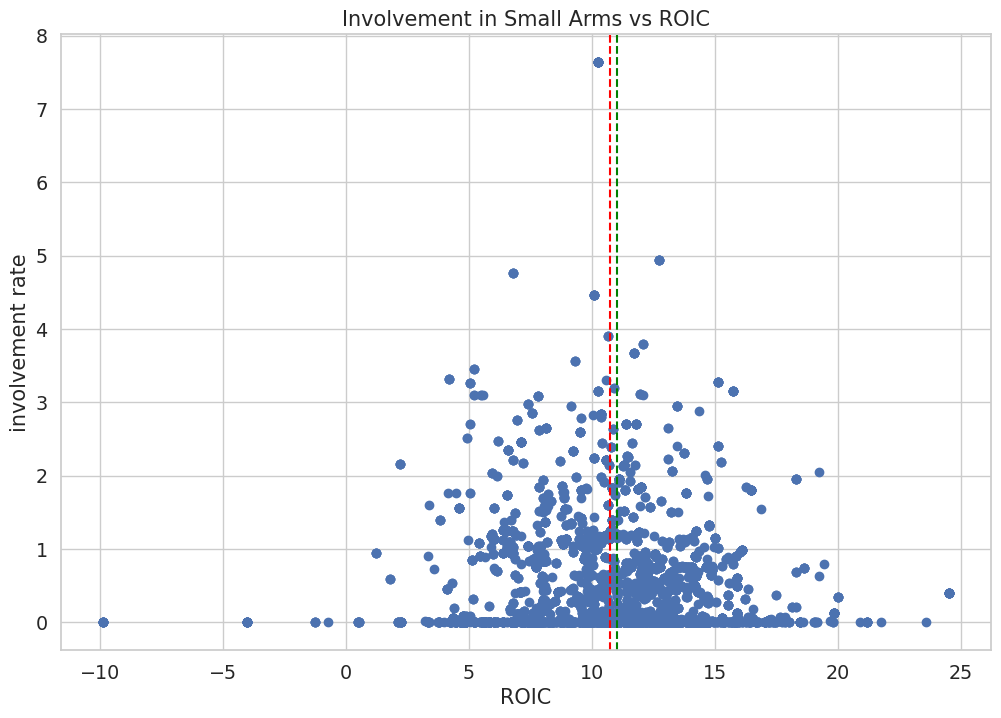

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(dropped_train_df['roic'], dropped_train_df['involvement_small_arms'], label='Scatter Plot')

plt.title('Involvement in Small Arms vs ROIC')
plt.xlabel('ROIC')
plt.ylabel('involvement rate')
plt.axvline(x=mean_value, color='red', linestyle='--', label='roic mean')
plt.axvline(x=median_value, color='green', linestyle='--', label='roic median')


plt.show()

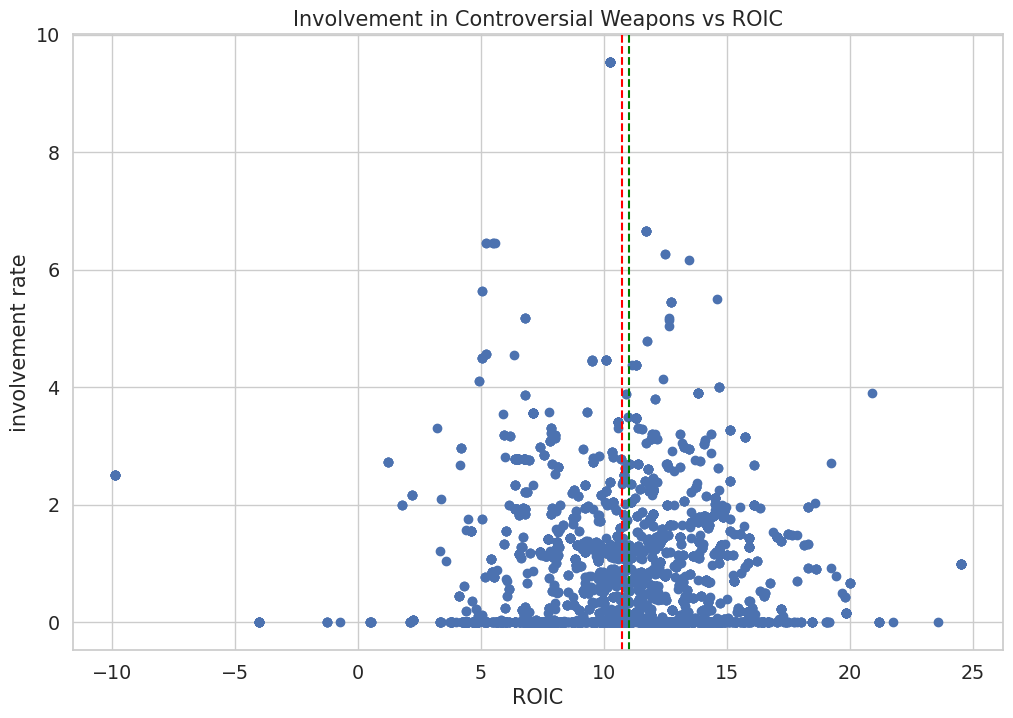

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(dropped_train_df['roic'], dropped_train_df['involvement_controversial_weapons'], label='Scatter Plot')

plt.title('Involvement in Controversial Weapons vs ROIC')
plt.xlabel('ROIC')
plt.ylabel('involvement rate')
plt.axvline(x=mean_value, color='red', linestyle='--', label='roic mean')
plt.axvline(x=median_value, color='green', linestyle='--', label='roic median')


plt.show()

# Regression

## Data Preprocessing

Melakukan encoding terhadap nilai data pada kolom kategorikal. Mengubah nilai pada kolom kategori menjadi nilai persentase date tersebut terhadap nilai kategori pada row lainnya. Kemudian untuk kolom kategorikal lainnya dilakukan one-hot encoder.

In [ ]:
categorical_cols = dropped_train_df.select_dtypes(include=['object']).columns
train_unique_values = dropped_train_df[categorical_cols].apply(lambda col: col.nunique())
train_unique_values

category                    196
equity_style                  3
equity_size                   3
nav_per_share_currency       17
shareclass_size_currency     15
fund_size_currency           13
dtype: int64

In [ ]:
test_unique_values = dropped_test_df[categorical_cols].apply(lambda col: col.nunique())
test_unique_values

category                    154
equity_style                  3
equity_size                   3
nav_per_share_currency       16
shareclass_size_currency     13
fund_size_currency           12
dtype: int64

In [ ]:
category_counts = dropped_train_df['category'].value_counts(normalize=True)
dropped_train_df['category'] = dropped_train_df['category'].map(category_counts)

df_encoded = pd.get_dummies(dropped_train_df, columns=['equity_style', 'equity_size'])

df_encoded = pd.get_dummies(df_encoded, columns=['nav_per_share_currency', 'shareclass_size_currency', 'fund_size_currency'])
df_encoded.shape

(22420, 145)

In [ ]:
category_counts = dropped_test_df['category'].value_counts(normalize=True)
dropped_test_df['category'] = dropped_test_df['category'].map(category_counts)

test_encoded = pd.get_dummies(dropped_test_df, columns=['equity_style', 'equity_size'])

test_encoded = pd.get_dummies(test_encoded, columns=['nav_per_share_currency', 'shareclass_size_currency', 'fund_size_currency'])
test_encoded.shape

(2803, 140)

In [ ]:
for col in df_encoded.columns:
    if col not in test_encoded.columns:
        test_encoded[col] = 0

test_encoded = test_encoded[df_encoded.columns]
test_encoded.shape

(2803, 145)

Melakukan impute data null dengan menggunakan metode K Nearest Neighboor

In [ ]:
from sklearn.impute import KNNImputer

# Exclude columns related to "C02 Emission" from the imputation process
columns_to_exclude = ['long_term_projected_earnings_growth']  # Add the actual column names you want to exclude

# Create a KNNImputer with 5 neighbors
imputer = KNNImputer(n_neighbors=5)

# Filter the columns to exclude from the imputation
columns_for_imputation = [col for col in df_encoded.columns if col not in columns_to_exclude]

# Fit and transform the DataFrame
ready_df_imputed = df_encoded.copy()
ready_df_imputed[columns_for_imputation] = imputer.fit_transform(df_encoded[columns_for_imputation])

# Convert the NumPy array back to a pandas DataFrame with the original column names
ready_df_imputed = pd.DataFrame(ready_df_imputed, columns=df_encoded.columns)

# Fit and transform the DataFrame
test_df_imputed = test_encoded.copy()
test_df_imputed[columns_for_imputation] = imputer.transform(test_encoded[columns_for_imputation])

# Convert the NumPy array back to a pandas DataFrame with the original column names
test_df_imputed = pd.DataFrame(test_df_imputed, columns=test_encoded.columns)

Melakukan antisipasi data outliers

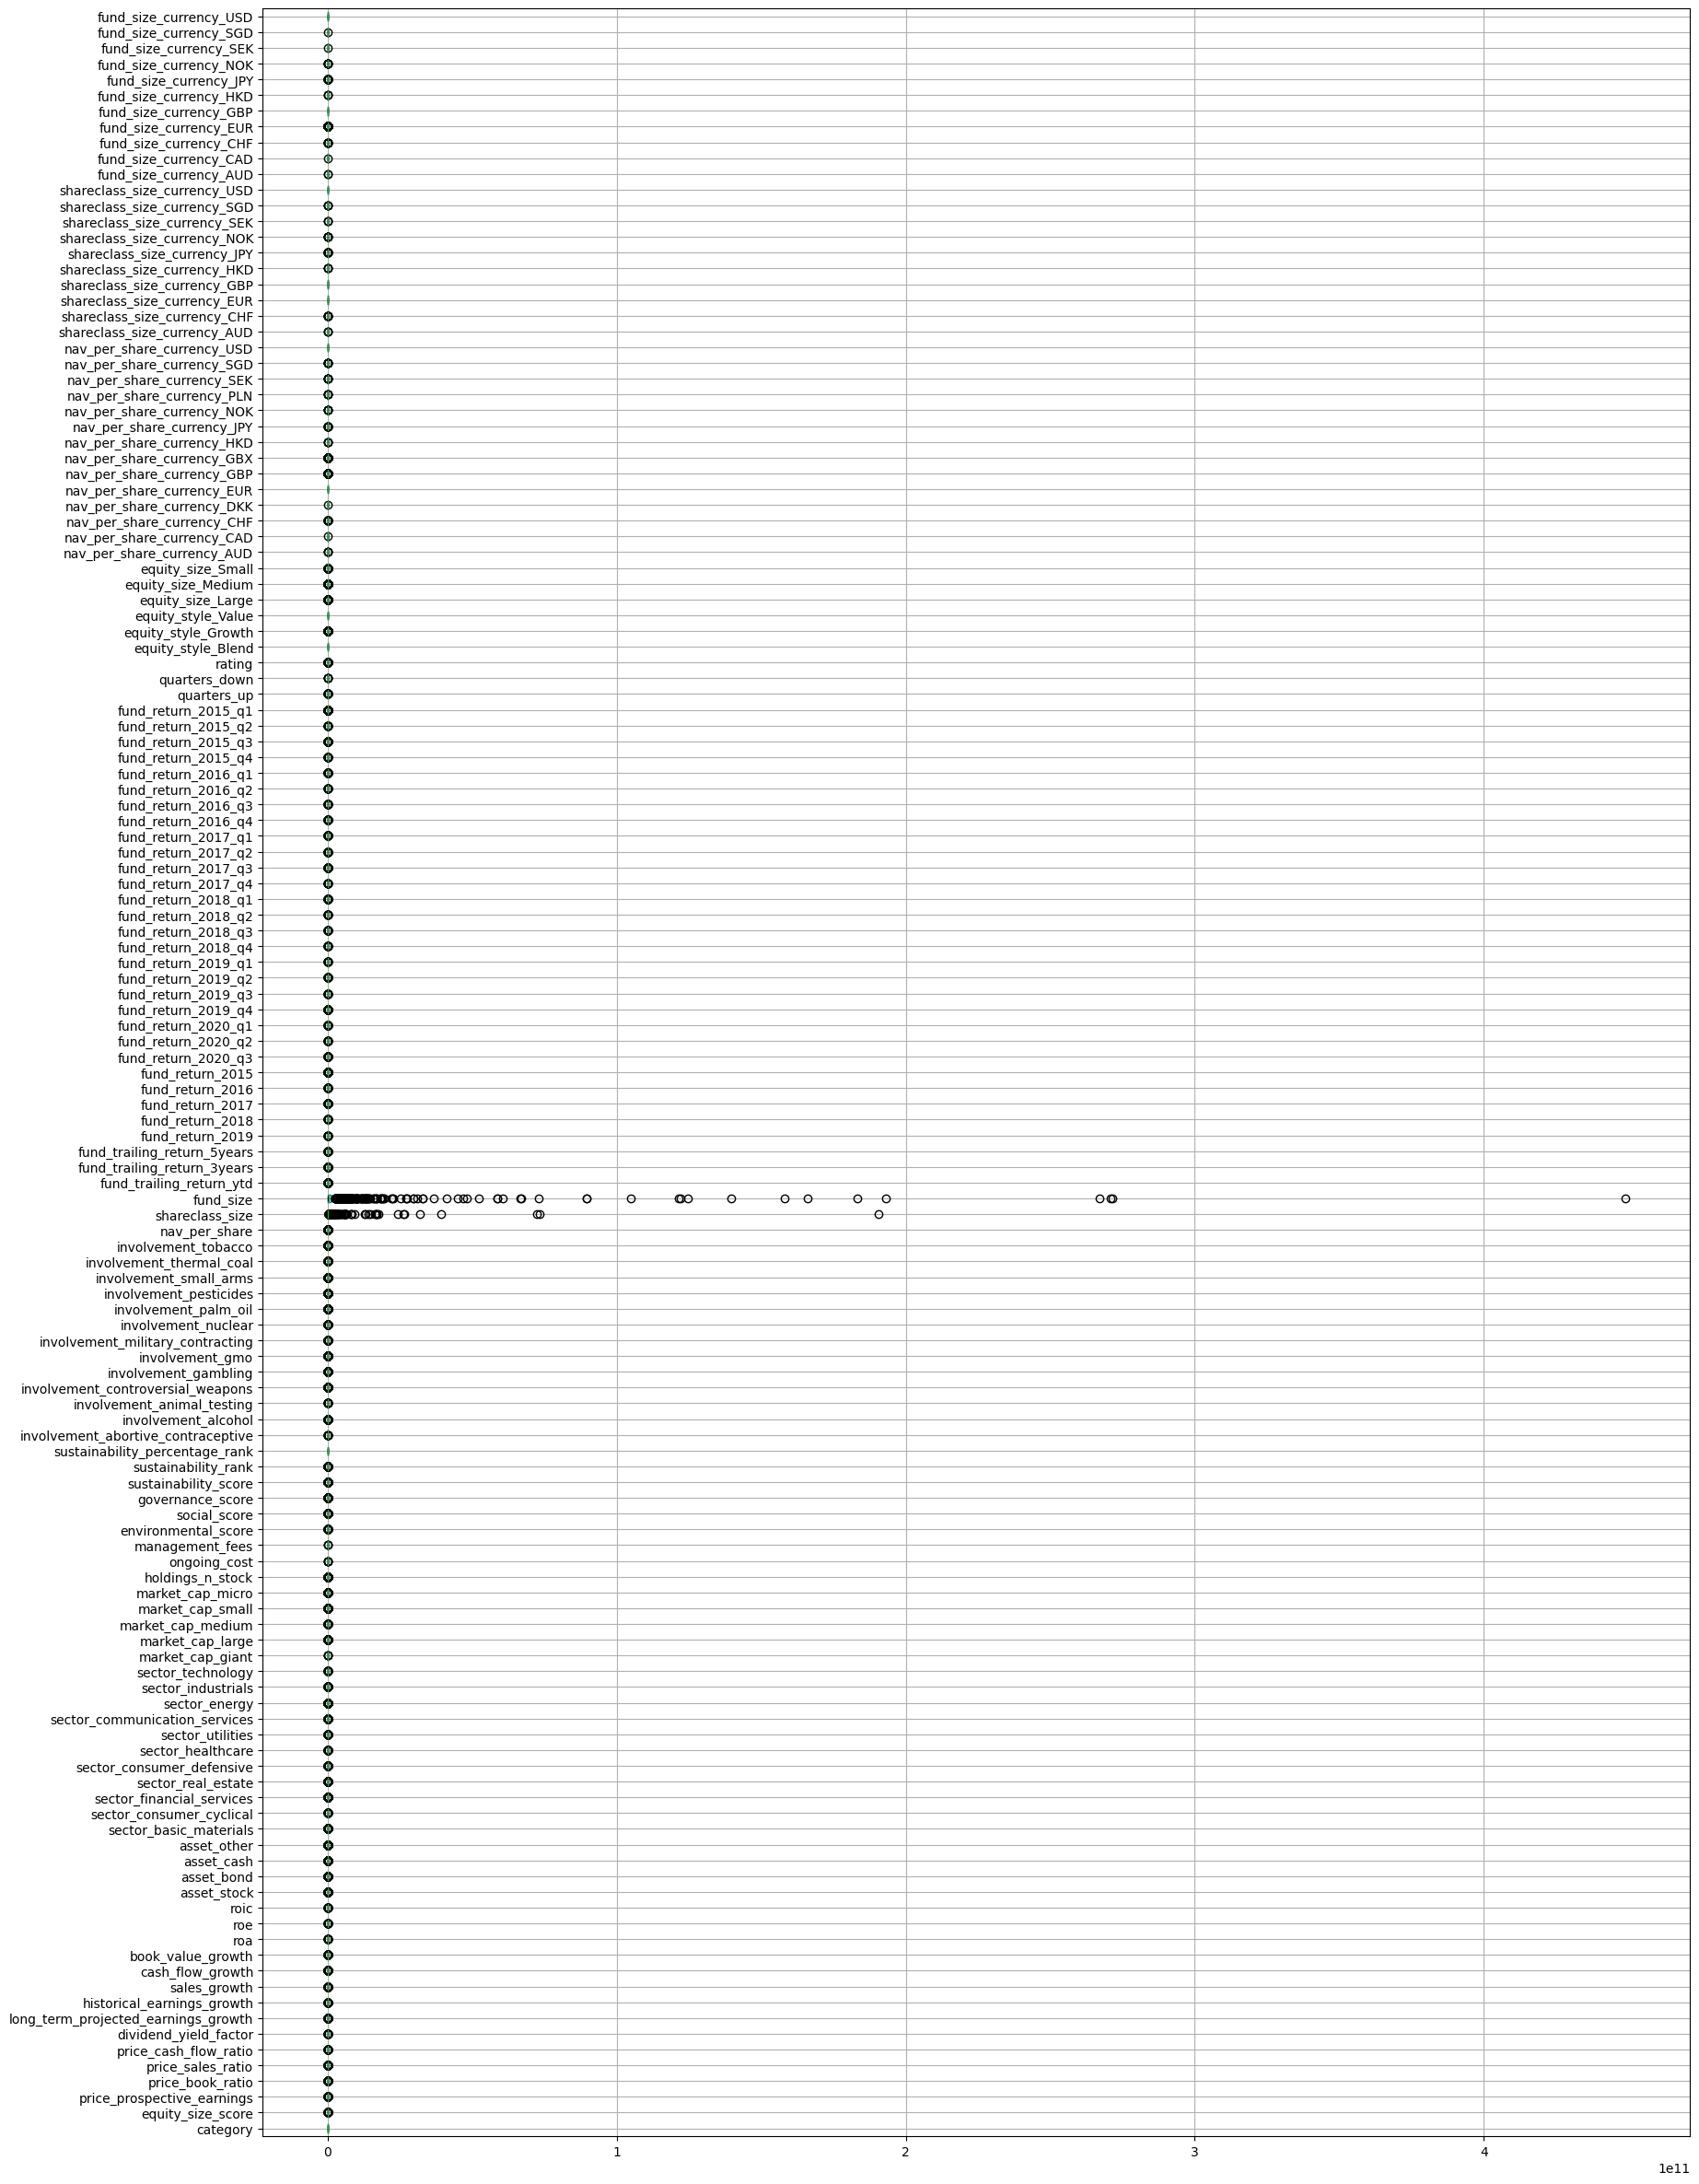

In [ ]:
ready_df_imputed.boxplot(vert=False, figsize=(20,30))
plt.show()

Drop data yang merupakan outlier pada kolom fund_size dan shareclass_size seperti yang terlihat pada plot di atas outlier

In [ ]:
ready_df_imputed = remove_outliers(ready_df_imputed, 'shareclass_size')

In [ ]:
ready_df_imputed = remove_outliers(ready_df_imputed, 'fund_size')

In [ ]:
ready_df_imputed.shape

(16764, 145)

Melakukan scaling pada data yang numerik

In [ ]:
# List of all columns in the dataset
all_columns = ready_df_imputed.columns

# Columns that should be excluded from scaling:
# The original 'category' column and any columns that contain 'nav_per_share_currency', 'shareclass_size_currency', or 'fund_size_currency'
exclude_columns = ['category'] + [col for col in all_columns if any(currency_col in col for currency_col in ['nav_per_share_currency', 'shareclass_size_currency', 'fund_size_currency', 'equity_size', 'equity_style', 'long_term_projected_earnings_growth'])]

# Columns to be scaled: All columns except the ones to be excluded
features_to_scale = [col for col in all_columns if col not in exclude_columns]

# Displaying the columns that will be scaled and those that will be excluded
features_to_scale, exclude_columns

(['price_prospective_earnings',
  'price_book_ratio',
  'price_sales_ratio',
  'price_cash_flow_ratio',
  'dividend_yield_factor',
  'historical_earnings_growth',
  'sales_growth',
  'cash_flow_growth',
  'book_value_growth',
  'roa',
  'roe',
  'roic',
  'asset_stock',
  'asset_bond',
  'asset_cash',
  'asset_other',
  'sector_basic_materials',
  'sector_consumer_cyclical',
  'sector_financial_services',
  'sector_real_estate',
  'sector_consumer_defensive',
  'sector_healthcare',
  'sector_utilities',
  'sector_communication_services',
  'sector_energy',
  'sector_industrials',
  'sector_technology',
  'market_cap_giant',
  'market_cap_large',
  'market_cap_medium',
  'market_cap_small',
  'market_cap_micro',
  'holdings_n_stock',
  'ongoing_cost',
  'management_fees',
  'environmental_score',
  'social_score',
  'governance_score',
  'sustainability_score',
  'sustainability_rank',
  'sustainability_percentage_rank',
  'involvement_abortive_contraceptive',
  'involvement_alcohol',
 

In [ ]:
scaler = StandardScaler()

y = ready_df_imputed['long_term_projected_earnings_growth']
X = ready_df_imputed.drop(['long_term_projected_earnings_growth'], axis=1)

X[features_to_scale] = scaler.fit_transform(X[features_to_scale])
X_final = test_df_imputed.copy().drop(['long_term_projected_earnings_growth'], axis=1)
X_final[features_to_scale] = scaler.transform(X_final[features_to_scale])

## Split data train

Melakukan splitting data train untuk melakukan evaluasi dengan beberapa metriks untuk menentukan performa model

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
xgb_params = {
    'n_estimators': 3000,        # Number of boosting rounds (trees)
    'learning_rate': 0.1,      # Step size shrinkage used in update to prevent overfitting
    'max_depth': 3,            # Maximum depth of the individual trees
    'min_child_weight': 1,     # Minimum sum of instance weight (hessian) needed in a child
    'gamma': 0,                # Minimum loss reduction required to make a further partition on a leaf node
    'subsample': 1.0,          # Fraction of samples used for fitting the trees (1.0 means using all samples)
    'colsample_bytree': 1.0,   # Fraction of features used for fitting the trees (1.0 means using all features)
    'objective': 'reg:squarederror',  # Objective function for regression tasks
    'eval_metric': 'rmse',     # Evaluation metric for regression tasks
    'random_state': 42         # Random seed for reproducibility
}

## Modeling

### Eksperimen 1: XGB Regressor

Mencoba menggunakan model Xtreme Gradient Boosting Regressor (XGBoost Regressor)

In [ ]:
xgb_regressor = XGBRegressor(**xgb_params)

# Fit the XGBRegressor model on the training data
xgb_regressor.fit(X_train, y_train)

# Make predictions on the test data
xgb_reg_result = xgb_regressor.predict(X_test)

Melakukan evaluasi model dengan menggunakan beberapa evaluation metriks

In [ ]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, xgb_reg_result)
mse = mean_squared_error(y_test, xgb_reg_result)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, xgb_reg_result)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")

# Print Cross validation score
print(f"Cross Validation Score: {np.mean(cross_val_score(xgb_regressor, X_train, y_train, cv=5))}")

Mean Absolute Error (MAE): 0.4000680652434101
Mean Squared Error (MSE): 0.6325443549853589
Root Mean Squared Error (RMSE): 0.7953265712808537
R-squared (R2) Score: 0.9550842420303356
Cross Validation Score: 0.9324131206067963


Train model dengan menggunakan seluruh data

In [ ]:
xgb_regressor_submission = XGBRegressor(**xgb_params)

# Fit the XGBRegressor model on the training data
xgb_regressor_submission.fit(X, y)

# Make predictions on the test data
xgb_reg_result_submission = xgb_regressor_submission.predict(X_final)

mengubah data ke dalam .csv untuk dikumpulkan

In [ ]:
eim_test = pd.read_csv('EuropeanInvestmentManagement_test_regress.csv')

prediction_df = pd.DataFrame({
    "ticker": eim_test["ticker"],
    "long_term_projected_earnings_growth": xgb_reg_result_submission
})

prediction_df.to_csv('RegressionPrediction.csv', index=False)



Mencoba menggunakan Light Gradient Boosting Machine Regressor (LGBM Regressor)

In [ ]:
lgbm_params = {
    'n_estimators': 2500,           # Number of boosting rounds (trees)
    'learning_rate': 0.1,         # Step size shrinkage used in update to prevent overfitting
    'max_depth': -1,              # Maximum depth of the individual trees (-1 means no limit)
    'min_child_samples': 20,      # Minimum number of data points to create a leaf
    'subsample': 1.0,            # Fraction of samples used for fitting the trees (1.0 means using all samples)
    'colsample_bytree': 1.0,      # Fraction of features used for fitting the trees (1.0 means using all features)
    'objective': 'regression',    # Objective function for regression tasks
    'metric': 'rmse',             # Evaluation metric for regression tasks
    'random_state': 42            # Random seed for reproducibility
}

In [ ]:
# Initialize the LGBMRegressor with your desired parameters
lgbm_regressor = LGBMRegressor(**lgbm_params)  # Replace lgbm_params with your desired hyperparameters

# Fit the LGBMRegressor model on the training data
lgbm_regressor.fit(X_train, y_train)

# Make predictions on the test data
lgbm_reg_result = lgbm_regressor.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22238
[LightGBM] [Info] Number of data points in the train set: 13411, number of used features: 121
[LightGBM] [Info] Start training from score 10.099656


Melakukan evaluasi model dengan menggunakan beberapa evaluation metriks

In [ ]:
mae = mean_absolute_error(y_test, lgbm_reg_result)
mse = mean_squared_error(y_test, lgbm_reg_result)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, lgbm_reg_result)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")

# Print Cross validation score
print(f"Cross Validation Score: {np.mean(cross_val_score(lgbm_regressor, X_train, y_train, cv=5))}")

Mean Absolute Error (MAE): 0.30041510892782125
Mean Squared Error (MSE): 0.5379279565660453
Root Mean Squared Error (RMSE): 0.7334357208140638
R-squared (R2) Score: 0.9618027704906229
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22217
[LightGBM] [Info] Number of data points in the train set: 10728, number of used features: 121
[LightGBM] [Info] Start training from score 10.107399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22215
[LightGBM] [Info] Number of data points in the train set: 10729, number of used features: 121
[LightGBM] [Info] Start training from score 10.090952
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008789 seconds.
You can set `force_col

### Eksperimen 2: Catboost

Mencoba menggunakan model Catboost

In [ ]:
catboost_params = {
    'iterations': 2000,            # Number of boosting iterations (trees)
    'learning_rate': 0.1,         # Step size shrinkage used in update to prevent overfitting
    'depth': 6,                   # Maximum depth of the individual trees
    'l2_leaf_reg': 3.0,           # L2 regularization term on weights
    'bagging_temperature': 1.0,   # Controls intensity of Bayesian bagging
    'random_seed': 42,            # Random seed for reproducibility
    'loss_function': 'RMSE'       # Loss function for regression tasks (Root Mean Squared Error)
}

In [ ]:
ccl = CatBoostRegressor(**catboost_params)
ccl.fit(X_train, y_train)
clas_result = ccl.predict(X_test)

0:	learn: 3.9653265	total: 22.7ms	remaining: 45.4s
1:	learn: 3.8520894	total: 40.1ms	remaining: 40.1s
2:	learn: 3.7461822	total: 58.6ms	remaining: 39s
3:	learn: 3.6613821	total: 75.5ms	remaining: 37.7s
4:	learn: 3.5780540	total: 92.9ms	remaining: 37.1s
5:	learn: 3.4896823	total: 110ms	remaining: 36.7s
6:	learn: 3.4227379	total: 128ms	remaining: 36.3s
7:	learn: 3.3499341	total: 145ms	remaining: 36.1s
8:	learn: 3.2796976	total: 162ms	remaining: 35.9s
9:	learn: 3.2200812	total: 180ms	remaining: 35.8s
10:	learn: 3.1650084	total: 201ms	remaining: 36.4s
11:	learn: 3.1182012	total: 227ms	remaining: 37.7s
12:	learn: 3.0721151	total: 248ms	remaining: 37.9s
13:	learn: 3.0296516	total: 271ms	remaining: 38.4s
14:	learn: 2.9874967	total: 289ms	remaining: 38.2s
15:	learn: 2.9384275	total: 308ms	remaining: 38.2s
16:	learn: 2.9026799	total: 328ms	remaining: 38.2s
17:	learn: 2.8612427	total: 346ms	remaining: 38.1s
18:	learn: 2.8273213	total: 367ms	remaining: 38.2s
19:	learn: 2.7984231	total: 387ms	rema

Melakukan evaluasi model dengan menggunakan beberapa evaluation metriks

In [ ]:
mae = mean_absolute_error(y_test, clas_result)
mse = mean_squared_error(y_test, clas_result)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, clas_result)

# Print Cross validation score
print(f"Cross Validation Score: {np.mean(cross_val_score(ccl, X_train, y_train, cv=5))}")

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")

Streaming output truncated to the last 5000 lines.
1005:	learn: 0.3478969	total: 21.8s	remaining: 21.5s
1006:	learn: 0.3477469	total: 21.8s	remaining: 21.5s
1007:	learn: 0.3473331	total: 21.8s	remaining: 21.5s
1008:	learn: 0.3469863	total: 21.9s	remaining: 21.5s
1009:	learn: 0.3465315	total: 21.9s	remaining: 21.4s
1010:	learn: 0.3459914	total: 21.9s	remaining: 21.4s
1011:	learn: 0.3456617	total: 21.9s	remaining: 21.4s
1012:	learn: 0.3452594	total: 21.9s	remaining: 21.4s
1013:	learn: 0.3449567	total: 22s	remaining: 21.4s
1014:	learn: 0.3445023	total: 22s	remaining: 21.3s
1015:	learn: 0.3437970	total: 22s	remaining: 21.3s
1016:	learn: 0.3434987	total: 22s	remaining: 21.3s
1017:	learn: 0.3432260	total: 22s	remaining: 21.2s
1018:	learn: 0.3429654	total: 22s	remaining: 21.2s
1019:	learn: 0.3424469	total: 22.1s	remaining: 21.2s
1020:	learn: 0.3421004	total: 22.1s	remaining: 21.2s
1021:	learn: 0.3416858	total: 22.1s	remaining: 21.1s
1022:	learn: 0.3412326	total: 22.1s	remaining: 21.1s
1023:	l

### Eksperimen 3: Random Forest

Mencoba menggunakan model random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor


rf_reg_tuned = RandomForestRegressor(min_samples_split=10, max_depth=None, criterion="squared_error")
rf_reg_tuned.fit(X_train, y_train)

rf_prediction_tuned = rf_reg_tuned.predict(X_test)

Melakukan evaluasi model dengan menggunakan beberapa evaluation metriks

In [ ]:
mae = mean_absolute_error(y_test, rf_prediction_tuned)
mse = mean_squared_error(y_test, rf_prediction_tuned)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, rf_prediction_tuned)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")
print(f"Cross Validation Score: {np.mean(cross_val_score(rf_reg_tuned, X_train, y_train, cv=5))}")

Mean Absolute Error (MAE): 0.4115484343077137
Mean Squared Error (MSE): 0.9355845481299205
Root Mean Squared Error (RMSE): 0.9672561957051092
R-squared (R2) Score: 0.9335659408027852
Cross Validation Score: 0.8984663967247126


# Classification

## Data Preprocessing

Melakukan encoding data sama seperti yang dilakukan di bagian regression

In [ ]:
category_counts = dropped_test_class_df['category'].value_counts(normalize=True)
dropped_test_class_df['category'] = dropped_test_class_df['category'].map(category_counts)

test_encoded_class = pd.get_dummies(dropped_test_class_df, columns=['equity_style', 'equity_size'])

test_encoded_class = pd.get_dummies(test_encoded_class, columns=['nav_per_share_currency', 'shareclass_size_currency', 'fund_size_currency'])
test_encoded_class.shape

(2802, 138)

In [ ]:
for col in df_encoded.columns:
    if col not in test_encoded_class.columns:
        test_encoded_class[col] = 0

test_encoded_class = test_encoded_class[df_encoded.columns]
test_encoded_class.shape

(2802, 145)

Melakukan impute data null dengan menggunakan metode K Nearest Neighboor

In [ ]:
from sklearn.impute import KNNImputer

# Exclude columns related to "C02 Emission" from the imputation process
columns_to_exclude = ['rating']  # Add the actual column names you want to exclude

# Create a KNNImputer with 5 neighbors
imputer = KNNImputer(n_neighbors=5)

# Filter the columns to exclude from the imputation
columns_for_imputation = [col for col in df_encoded.columns if col not in columns_to_exclude]

# Fit and transform the DataFrame
ready_df_imputed_class = df_encoded.copy()
ready_df_imputed_class[columns_for_imputation] = imputer.fit_transform(df_encoded[columns_for_imputation])

# Convert the NumPy array back to a pandas DataFrame with the original column names
ready_df_imputed_class = pd.DataFrame(ready_df_imputed_class, columns=df_encoded.columns)

# Fit and transform the DataFrame
test_df_imputed_class = test_encoded_class.copy()
test_df_imputed_class[columns_for_imputation] = imputer.transform(test_encoded_class[columns_for_imputation])

# Convert the NumPy array back to a pandas DataFrame with the original column names
test_df_imputed_class = pd.DataFrame(test_df_imputed_class, columns=test_encoded_class.columns)

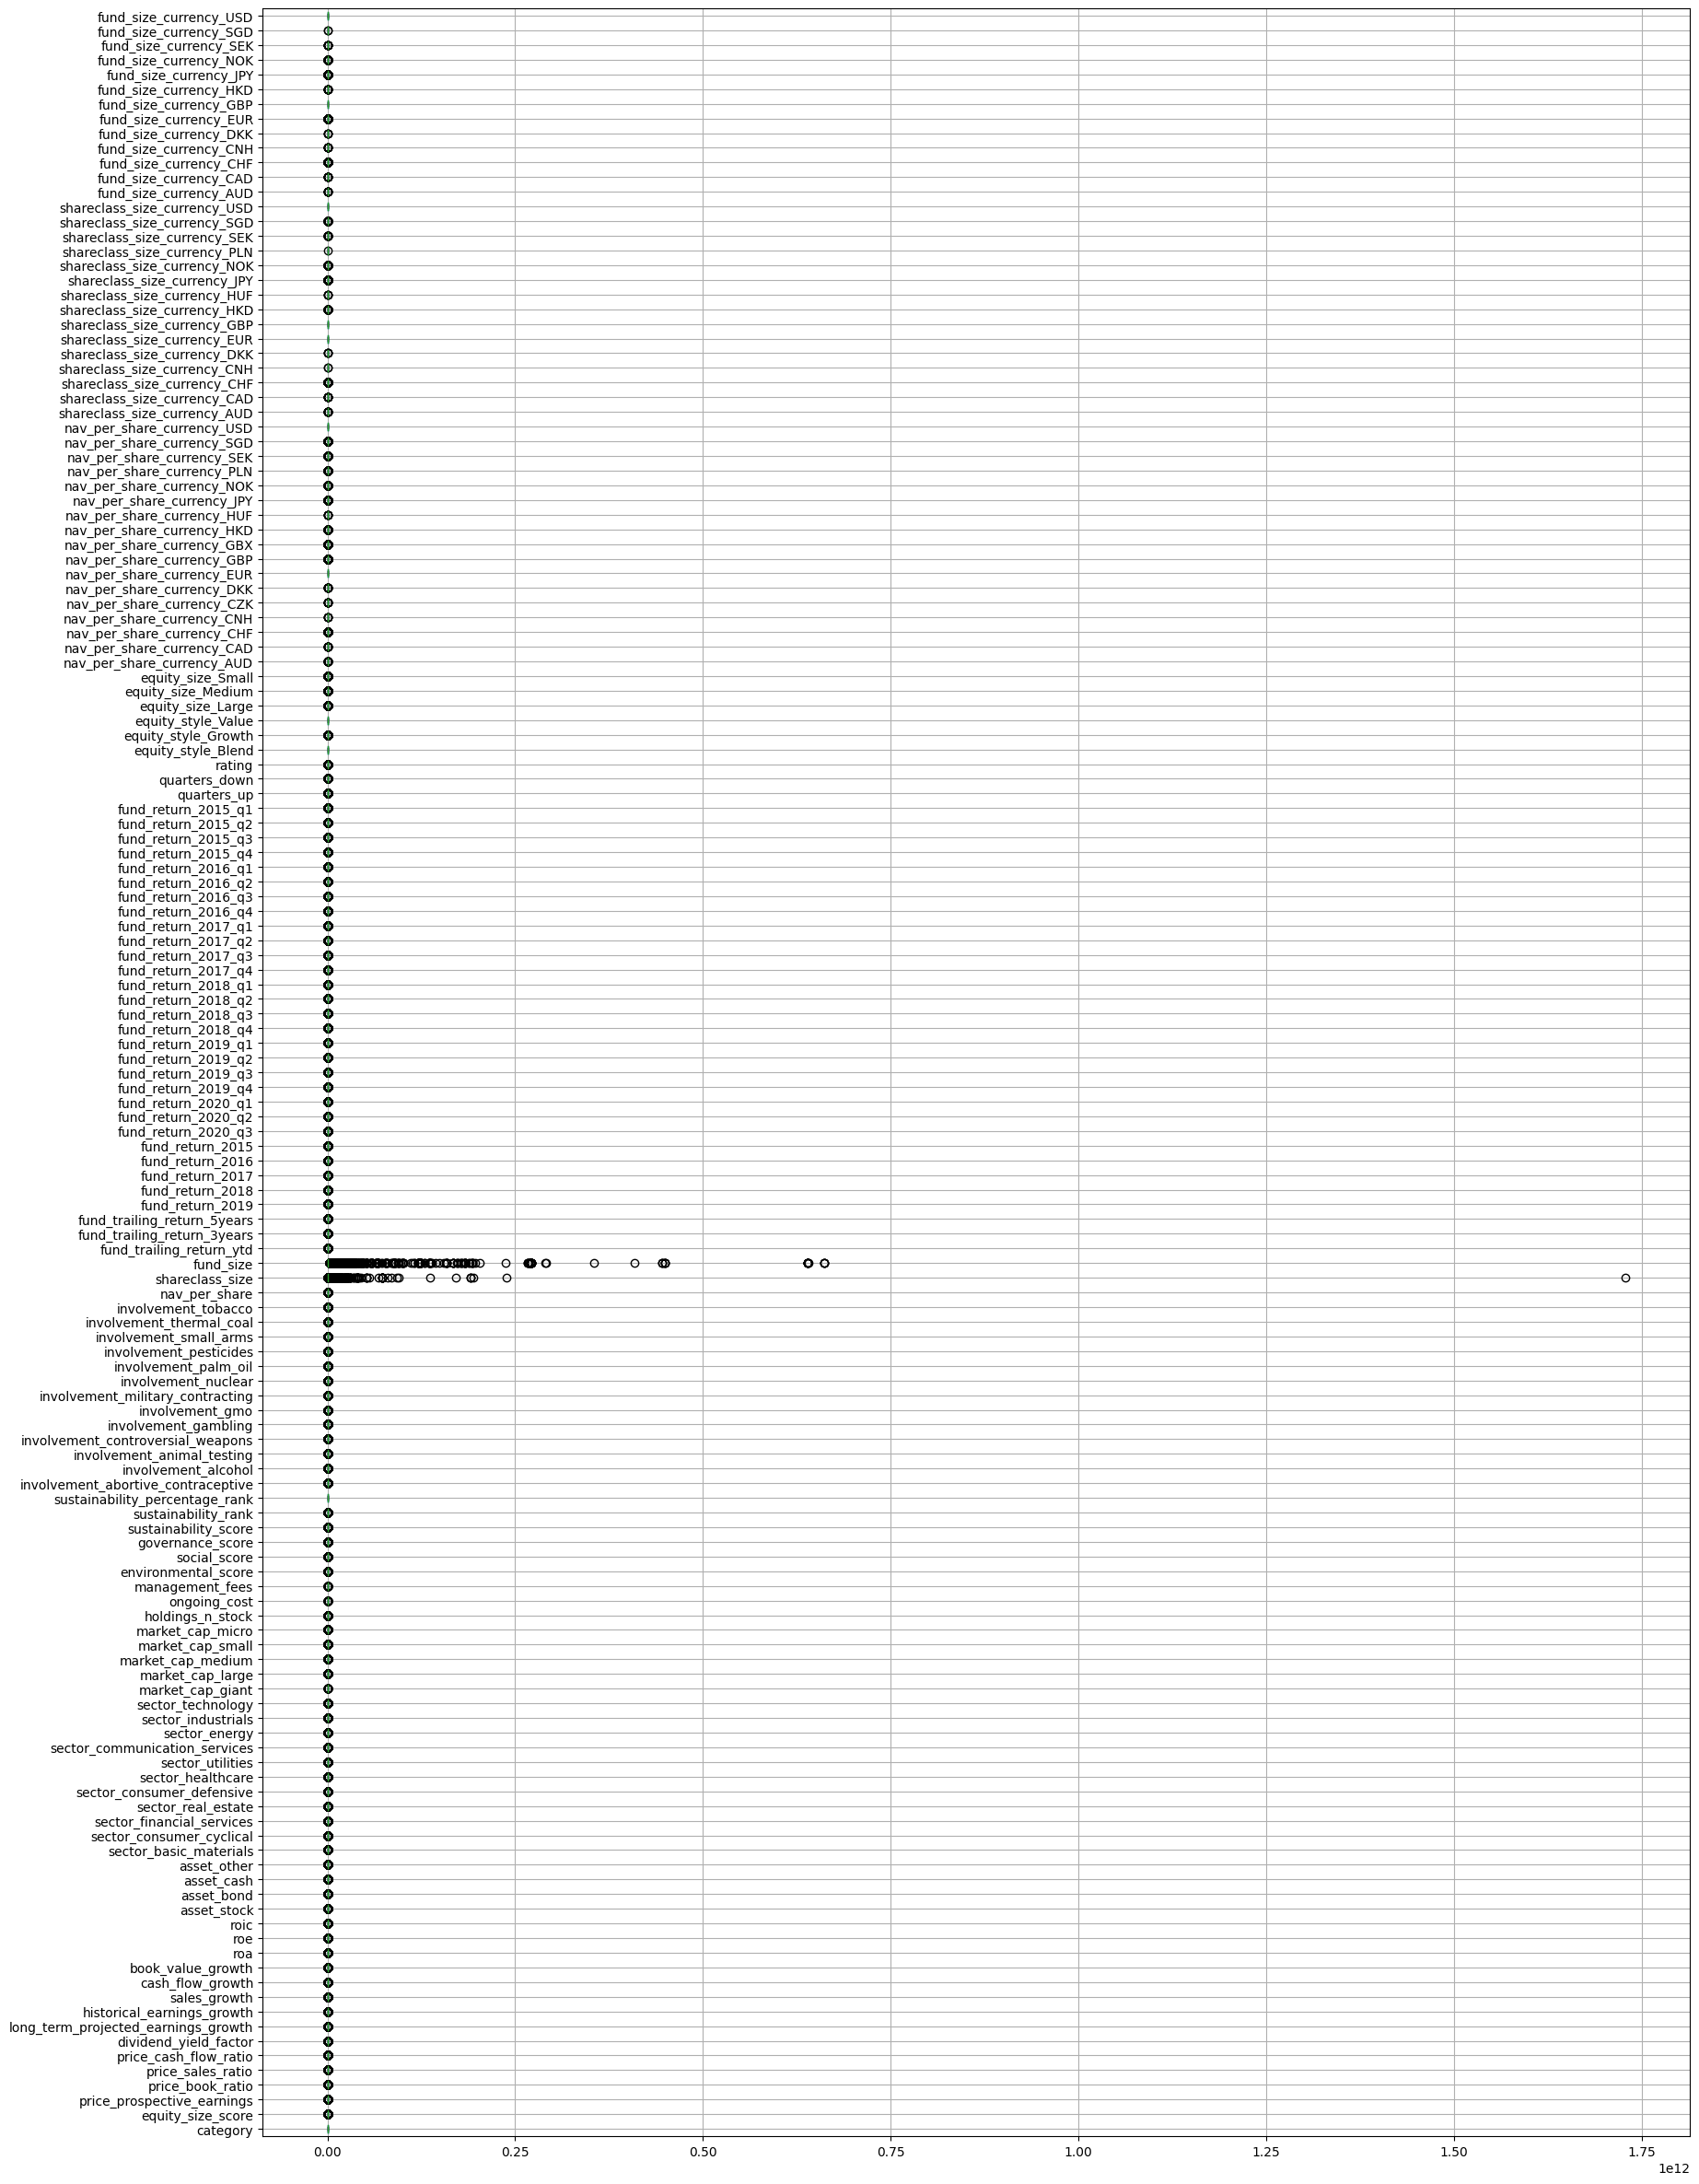

In [ ]:
ready_df_imputed_class.boxplot(vert=False, figsize=(20,30))
plt.show()

Menghilangkan nilai outliers sesuai dengan box plot di atas yang mana outliers yang terlihat hanya ada pada dua kolom, yaitu shareclass_size dan fund_size

In [ ]:
ready_df_imputed_class = remove_outliers(ready_df_imputed_class, 'shareclass_size')

In [ ]:
ready_df_imputed_class = remove_outliers(ready_df_imputed_class, 'fund_size')


Melakukan scaling pada data numerik

In [ ]:
# List of all columns in the dataset
all_columns = ready_df_imputed_class.columns

# Columns that should be excluded from scaling:
# The original 'category' column and any columns that contain 'nav_per_share_currency', 'shareclass_size_currency', or 'fund_size_currency'
exclude_columns_class = ['category'] + [col for col in all_columns if any(currency_col in col for currency_col in ['nav_per_share_currency', 'shareclass_size_currency', 'fund_size_currency', 'equity_size', 'equity_style', 'rating'])]

# Columns to be scaled: All columns except the ones to be excluded
features_to_scale_class = [col for col in all_columns if col not in exclude_columns_class]

# Displaying the columns that will be scaled and those that will be excluded
features_to_scale_class, exclude_columns_class

(['price_prospective_earnings',
  'price_book_ratio',
  'price_sales_ratio',
  'price_cash_flow_ratio',
  'dividend_yield_factor',
  'long_term_projected_earnings_growth',
  'historical_earnings_growth',
  'sales_growth',
  'cash_flow_growth',
  'book_value_growth',
  'roa',
  'roe',
  'roic',
  'asset_stock',
  'asset_bond',
  'asset_cash',
  'asset_other',
  'sector_basic_materials',
  'sector_consumer_cyclical',
  'sector_financial_services',
  'sector_real_estate',
  'sector_consumer_defensive',
  'sector_healthcare',
  'sector_utilities',
  'sector_communication_services',
  'sector_energy',
  'sector_industrials',
  'sector_technology',
  'market_cap_giant',
  'market_cap_large',
  'market_cap_medium',
  'market_cap_small',
  'market_cap_micro',
  'holdings_n_stock',
  'ongoing_cost',
  'management_fees',
  'environmental_score',
  'social_score',
  'governance_score',
  'sustainability_score',
  'sustainability_rank',
  'sustainability_percentage_rank',
  'involvement_abortive_c

In [ ]:
scaler_class = StandardScaler()

y_class = ready_df_imputed_class['rating']
X_class = ready_df_imputed_class.drop(['rating'], axis=1)

X_class[features_to_scale_class] = scaler_class.fit_transform(X_class[features_to_scale_class])
X_final_class = test_df_imputed_class.copy().drop(['rating'], axis=1)
X_final_class[features_to_scale_class] = scaler_class.transform(X_final_class[features_to_scale_class])

## Split data train

Melakukan splitting data train untuk melakukan evaluasi dengan beberapa metriks untuk menentukan performa model

In [ ]:
from sklearn.model_selection import train_test_split

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)


## Modeling

### Eksperimen 1: XGB

Mencoba menggunakan model Xtreme Gradient Boosting Regressor (XGBoost Regressor)

In [ ]:
xgb_params_class = {
    'n_estimators': 1750,
    'learning_rate': 0.1,
}

In [ ]:
from xgboost import XGBClassifier


# Create an instance of XGBClassifier
xgb_classifier = XGBClassifier(**xgb_params_class)

y_train_xgb = y_train_class.astype(int)
y_test_xgb = y_test_class.astype(int)

xgb_enc = LabelEncoder()

y_train_encoded = xgb_enc.fit_transform(y_train_xgb)
y_test_encoded = xgb_enc.transform(y_test_xgb)

# Fit the XGBClassifier model on the training data
xgb_classifier.fit(X_train_class, y_train_encoded)

# Make predictions on the test data
xgb_clas_result = xgb_classifier.predict(X_test_class)


Melakukan evaluasi model dengan menggunakan beberapa evaluation metriks

In [ ]:
xgb_clas_result = xgb_enc.inverse_transform(xgb_clas_result)

In [ ]:
xgb_clas_result

array([2, 4, 1, ..., 3, 4, 3])

In [ ]:
accuracy = accuracy_score(y_test_class, xgb_clas_result)
class_report = classification_report(y_test_class, xgb_clas_result)
conf_matrix = confusion_matrix(y_test_class, xgb_clas_result)

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print(f"Cross Validation Score: {np.mean(cross_val_score(xgb_classifier, X_train_class, y_train_encoded, cv=stratified_cv))}")
# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Cross Validation Score: 0.7935098843715032
Accuracy: 0.8284606205250596
Classification Report:
               precision    recall  f1-score   support

         1.0       0.85      0.78      0.82       248
         2.0       0.82      0.79      0.81       712
         3.0       0.82      0.86      0.84      1247
         4.0       0.82      0.82      0.82       821
         5.0       0.88      0.85      0.86       324

    accuracy                           0.83      3352
   macro avg       0.84      0.82      0.83      3352
weighted avg       0.83      0.83      0.83      3352

Confusion Matrix:
 [[ 194   49    5    0    0]
 [  29  566  106    9    2]
 [   2   73 1070   97    5]
 [   0    5  113  673   30]
 [   2    0    4   44  274]]


Train dengan seluruh data

In [ ]:
from xgboost import XGBClassifier


# Create an instance of XGBClassifier
xgb_classifier = XGBClassifier(**xgb_params_class)

y_xgb = y_class.astype(int)

xgb_enc = LabelEncoder()

y_encoded = xgb_enc.fit_transform(y_xgb)

# Fit the XGBClassifier model on the training data
xgb_classifier.fit(X_class, y_encoded)

# Make predictions on the test data
xgb_clas_result = xgb_classifier.predict(X_final_class)


Mengubah data ke dalam .csv untuk dikumpulkan

In [ ]:
xgb_clas_result = xgb_enc.inverse_transform(xgb_clas_result)

In [ ]:
xgb_clas_result

array([3, 3, 2, ..., 4, 2, 3])

In [ ]:
eim_test = pd.read_csv('EuropeanInvestmentManagement_test_classification.csv')

prediction_df = pd.DataFrame({
    "ticker": eim_test["ticker"],
    "rating": xgb_clas_result
})

prediction_df.to_csv('ClassificationPrediction.csv', index=False)



### Eksperimen 2: LGBM

Mencoba menggunakan Light Gradient Boosting Machine Regressor (LGBM Regressor)

In [ ]:
catboost_params={'nan_mode': 'Min',
 'eval_metric': 'MultiClass',
 'iterations': 1500,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'eval_fraction': 0,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'use_best_model': False,
 'class_names': [1, 2, 3, 4, 5],
 'random_seed': 123,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'MultiClass',
 'learning_rate': 0.08972600102424622,
 'score_function': 'Cosine',
 'task_type': 'CPU',
 'leaf_estimation_iterations': 1,
 'bootstrap_type': 'Bayesian',
 'max_leaves': 64}

In [ ]:
ccl = CatBoostClassifier(**catboost_params)
ccl.fit(X_train_class, y_train_class)
clas_result = ccl.predict(X_test_class)

0:	learn: 1.5640738	total: 99.7ms	remaining: 2m 29s
1:	learn: 1.5282993	total: 172ms	remaining: 2m 8s
2:	learn: 1.4953822	total: 251ms	remaining: 2m 5s
3:	learn: 1.4635119	total: 328ms	remaining: 2m 2s
4:	learn: 1.4386026	total: 408ms	remaining: 2m 1s
5:	learn: 1.4166369	total: 487ms	remaining: 2m 1s
6:	learn: 1.3965980	total: 571ms	remaining: 2m 1s
7:	learn: 1.3779993	total: 648ms	remaining: 2m
8:	learn: 1.3621995	total: 726ms	remaining: 2m
9:	learn: 1.3485154	total: 825ms	remaining: 2m 2s
10:	learn: 1.3328425	total: 900ms	remaining: 2m 1s
11:	learn: 1.3182162	total: 983ms	remaining: 2m 1s
12:	learn: 1.3070644	total: 1.07s	remaining: 2m 2s
13:	learn: 1.2949381	total: 1.15s	remaining: 2m 2s
14:	learn: 1.2853399	total: 1.23s	remaining: 2m 2s
15:	learn: 1.2754429	total: 1.31s	remaining: 2m 1s
16:	learn: 1.2647246	total: 1.39s	remaining: 2m 1s
17:	learn: 1.2530413	total: 1.47s	remaining: 2m
18:	learn: 1.2433012	total: 1.55s	remaining: 2m
19:	learn: 1.2359453	total: 1.63s	remaining: 2m
20:

Melakukan evaluasi dengan menggunakan beberapa evaluation metriks

In [ ]:
accuracy = accuracy_score(y_test_class, clas_result)
class_report = classification_report(y_test_class, clas_result)
conf_matrix = confusion_matrix(y_test_class, clas_result)

# Print the evaluation metrics
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print(f"Cross Validation Score: {np.mean(cross_val_score(ccl, X_train_class, y_train_class, cv=stratified_cv))}")
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Streaming output truncated to the last 5000 lines.
1021:	learn: 0.2844703	total: 1m 18s	remaining: 36.8s
1022:	learn: 0.2843142	total: 1m 18s	remaining: 36.8s
1023:	learn: 0.2841074	total: 1m 19s	remaining: 36.7s
1024:	learn: 0.2839578	total: 1m 19s	remaining: 36.7s
1025:	learn: 0.2837488	total: 1m 19s	remaining: 36.6s
1026:	learn: 0.2833978	total: 1m 19s	remaining: 36.6s
1027:	learn: 0.2832654	total: 1m 19s	remaining: 36.5s
1028:	learn: 0.2830547	total: 1m 19s	remaining: 36.4s
1029:	learn: 0.2826943	total: 1m 19s	remaining: 36.4s
1030:	learn: 0.2825003	total: 1m 19s	remaining: 36.3s
1031:	learn: 0.2823175	total: 1m 20s	remaining: 36.3s
1032:	learn: 0.2821378	total: 1m 20s	remaining: 36.2s
1033:	learn: 0.2820480	total: 1m 20s	remaining: 36.2s
1034:	learn: 0.2817686	total: 1m 20s	remaining: 36.1s
1035:	learn: 0.2816758	total: 1m 20s	remaining: 36s
1036:	learn: 0.2814078	total: 1m 20s	remaining: 35.9s
1037:	learn: 0.2810585	total: 1m 20s	remaining: 35.9s
1038:	learn: 0.2807689	total: 1m 

Mencoba menggunakan Light Gradient Boosting Machine Regressor (LGBM Regressor)

In [ ]:
lgbm_params = {
    'n_estimators': 500,
    'learning_rate': 0.1,
    # Add other hyperparameters specific to LGBMClassifier here
}

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(**lgbm_params)
lgbm_clf.fit(X_train_class, y_train_class)

# Make predictions
clas_result = lgbm_clf.predict(X_test_class)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22482
[LightGBM] [Info] Number of data points in the train set: 13405, number of used features: 122
[LightGBM] [Info] Start training from score -2.617873
[LightGBM] [Info] Start training from score -1.566366
[LightGBM] [Info] Start training from score -0.979214
[LightGBM] [Info] Start training from score -1.426557
[LightGBM] [Info] Start training from score -2.277902


In [ ]:
accuracy = accuracy_score(y_test_class, clas_result)
class_report = classification_report(y_test_class, clas_result)
conf_matrix = confusion_matrix(y_test_class, clas_result)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print(f"Cross Validation Score: {np.mean(cross_val_score(lgbm_clf, X_train_class, y_train_class, cv=stratified_cv))}")

Accuracy: 0.8272673031026253
Classification Report:
               precision    recall  f1-score   support

         1.0       0.88      0.77      0.82       248
         2.0       0.82      0.81      0.81       712
         3.0       0.82      0.86      0.84      1247
         4.0       0.81      0.81      0.81       821
         5.0       0.87      0.81      0.84       324

    accuracy                           0.83      3352
   macro avg       0.84      0.81      0.83      3352
weighted avg       0.83      0.83      0.83      3352

Confusion Matrix:
 [[ 190   52    6    0    0]
 [  24  574  103    9    2]
 [   1   67 1078   98    3]
 [   0    2  118  667   34]
 [   1    2    3   54  264]]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22456
[LightGBM] [Info] Number of data points in the train set: 10724, number of used features: 121
[LightG

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define your Random Forest classifier parameters
rf_params = {
    'n_estimators': 100,  # Number of trees in the forest
    'max_depth': None,    # Maximum depth of the trees (None for full growth)
    # Add other hyperparameters specific to RandomForestClassifier here
}

# Initialize and train the RandomForestClassifier
rf_clf = RandomForestClassifier(**rf_params)
rf_clf.fit(X_train_class, y_train_class)

# Make predictions
clas_result = rf_clf.predict(X_test_class)


In [ ]:
accuracy = accuracy_score(y_test_class, clas_result)
class_report = classification_report(y_test_class, clas_result)
conf_matrix = confusion_matrix(y_test_class, clas_result)

# Print the evaluation metrics
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print(f"Cross Validation Score: {np.mean(cross_val_score(rf_clf, X_train_class, y_train_class, cv=stratified_cv))}")
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Cross Validation Score: 0.78082804923536
Accuracy: 0.8135441527446301
Classification Report:
               precision    recall  f1-score   support

         1.0       0.87      0.75      0.80       248
         2.0       0.82      0.79      0.80       712
         3.0       0.80      0.86      0.83      1247
         4.0       0.80      0.78      0.79       821
         5.0       0.86      0.81      0.83       324

    accuracy                           0.81      3352
   macro avg       0.83      0.80      0.81      3352
weighted avg       0.81      0.81      0.81      3352

Confusion Matrix:
 [[ 186   55    7    0    0]
 [  26  565  110   11    0]
 [   2   69 1076   97    3]
 [   0    2  142  637   40]
 [   1    1    7   52  263]]


# Clustering

## K Means Clustering

For n_clusters = 2 The average silhouette_coefficient is : 0.7021490707453601
For n_clusters = 3 The average silhouette_coefficient is : 0.6250800652492525
For n_clusters = 4 The average silhouette_coefficient is : 0.5507858665408099
For n_clusters = 5 The average silhouette_coefficient is : 0.5307436075045168
For n_clusters = 6 The average silhouette_coefficient is : 0.495826219085586
For n_clusters = 7 The average silhouette_coefficient is : 0.5310281183207121
For n_clusters = 8 The average silhouette_coefficient is : 0.5045355751358396


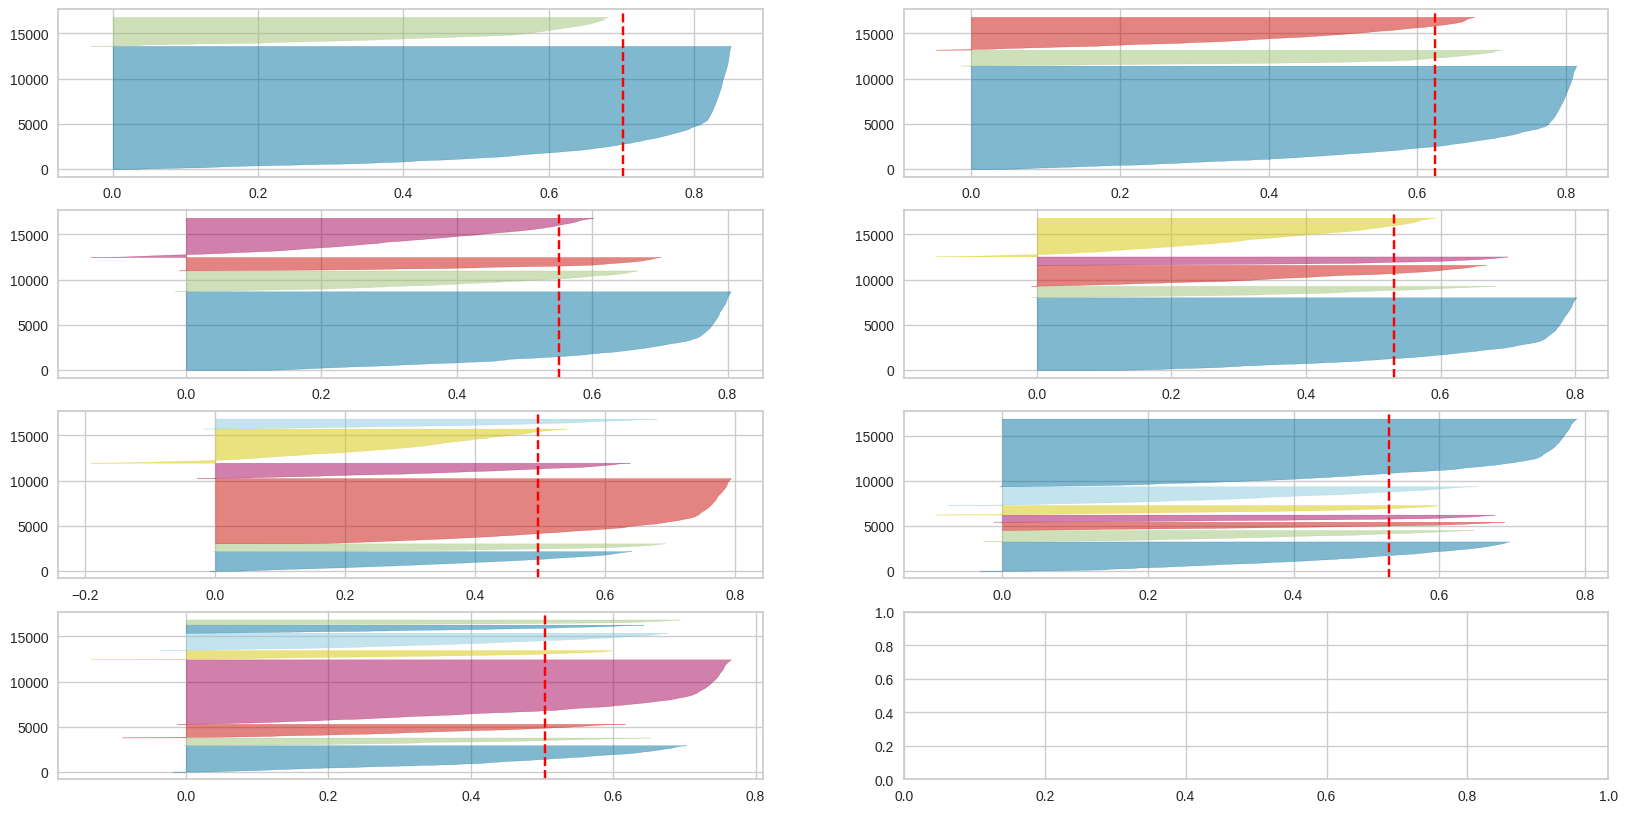

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

num_of_cluster = [2, 3, 4, 5, 6, 7, 8]

fig, ax = plt.subplots(4, 2, figsize=(20,10))
for k in num_of_cluster:
    # Create KMeans instance for different number of clusters
    clusterer = KMeans(n_clusters = k, n_init=10)

    # Draw silhouette diagram
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(clusterer, colors = 'yellowbrick', ax = ax[q-1][mod])
    visualizer.fit(ready_df_imputed)

    # Compute silhoutte score
    # This gives a perspective into the density and separation of the formed clusters
    cluster_labels = clusterer.fit_predict(ready_df_imputed)
    silhouette_avg = silhouette_score(ready_df_imputed, cluster_labels)
    print(
        "For n_clusters =",
        k,
        "The average silhouette_coefficient is :",
        silhouette_avg,
    )

In [ ]:
kmeans = KMeans(n_clusters=2)

cluster_assignment = kmeans.fit_predict(X)
data_cluster = pd.DataFrame(ready_df_imputed.copy())
data_cluster['Clusters'] = cluster_assignment
data_cluster.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


category  equity_style  equity_size  equity_size_score  \
1      35.0           2.0          2.0             124.69   
2      98.0           3.0          3.0             322.70   
3     129.0           1.0          3.0             229.67   
4     132.0           3.0          2.0             111.36   
7     144.0           2.0          3.0             275.85   

   price_prospective_earnings  price_book_ratio  price_sales_ratio  \
1                       23.06              1.97               1.70   
2                       27.99              3.04               2.71   
3                       17.19              1.77               0.75   
4                       12.15              1.01               0.62   
7                       16.36              1.96               1.39   

   price_cash_flow_ratio  dividend_yield_factor  \
1                  12.07                   1.30   
2                  10.35                   0.97   
3                   6.52                   2.73   
4                   3.54                   2.86   
7                  10.36                   2.44   

   long_term_projected_earnings_growth  historical_earnings_growth  \
1                                 9.34                      14.300   
2                                16.87                      14.558   
3                                 7.77                       3.170   
4                                10.02                     -14.020   
7                                 9.32                       3.460   

   sales_growth  cash_flow_growth  book_value_growth   roa    roe   roic  \
1          7.55              8.56               9.59  7.36  14.61  11.33   
2         13.80             21.53              14.76  7.83  16.35  11.62   
3          3.04             -0.32               1.86  4.68  17.51   8.65   
4        -16.23             -6.55              -2.83  1.86   7.77   2.02   
7          2.44              8.44               6.97  7.65  19.48  12.52   

   asset_stock  asset_bond  asset_cash  asset_other  sector_basic_materials  \
1        96.81        0.57        2.63        -0.01                    8.17   
2        95.92        0.00        2.21         1.87                    6.35   
3        99.98        0.00        0.21        -0.19                    3.01   
4       107.14        0.00       -7.14         0.00                   19.94   
7        34.63       53.25       11.13         0.97                    4.77   

   sector_consumer_cyclical  sector_financial_services  sector_real_estate  \
1                     14.42                      18.82               8.686   
2                     22.32                      10.82               0.440   
3                     14.47                      13.86               1.730   
4                      2.45                      16.94               1.210   
7                     11.32                      14.16               2.480   

   sector_consumer_defensive  sector_healthcare  sector_utilities  \
1                       2.96              15.34             1.590   
2                      11.74               3.37             4.384   
3                      11.37              10.43             1.390   
4                       2.83              16.24             4.000   
7                       7.46              13.52             2.580   

   sector_communication_services  sector_energy  sector_industrials  \
1                           8.44          3.586               17.32   
2                          17.14          4.960                4.39   
3                           8.46          3.270               16.32   
4                           9.42          0.960               15.72   
7                           8.10          2.070               14.84   

   sector_technology  market_cap_giant  market_cap_large  market_cap_medium  \
1              21.39              1.14              0.00              66.33   
2              23.42             62.38             21.08              11.85   
3      

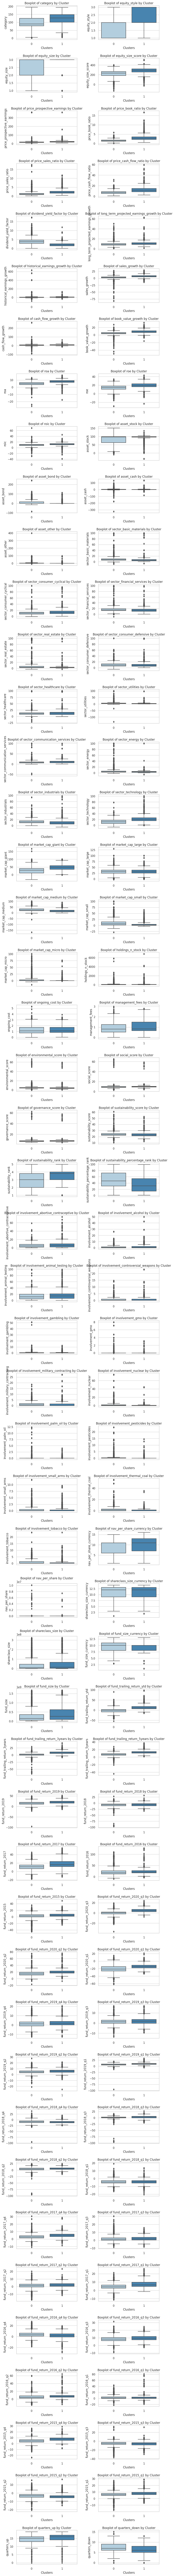

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="whitegrid")

num_features = len(data_cluster.columns[:-2])
N = int(np.ceil(num_features / 2))

# Create the subplots
fig, axes = plt.subplots(N, 2, figsize=(10, 3*N))
fig.tight_layout(pad=4.0)

for i, feature in enumerate(data_cluster.columns[:-2]):
    row, col = divmod(i, 2)
    sns.boxplot(x='Clusters', y=feature, data=data_cluster, palette="Blues", ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot of {feature} by Cluster')

if num_features % 2:
    axes[-1, -1].axis('off')

plt.show()

## Agglomerative Clustering

In [ ]:
import scipy.cluster.hierarchy as shc

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    shc.dendrogram(linkage_matrix, **kwargs)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(distance_threshold = 0, n_clusters = None, linkage = 'ward', affinity = 'euclidean')
clustering = model.fit(ready_df_imputed)
clustering.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


array([ 8767, 10921, 11270, ...,     3,     1,     0])

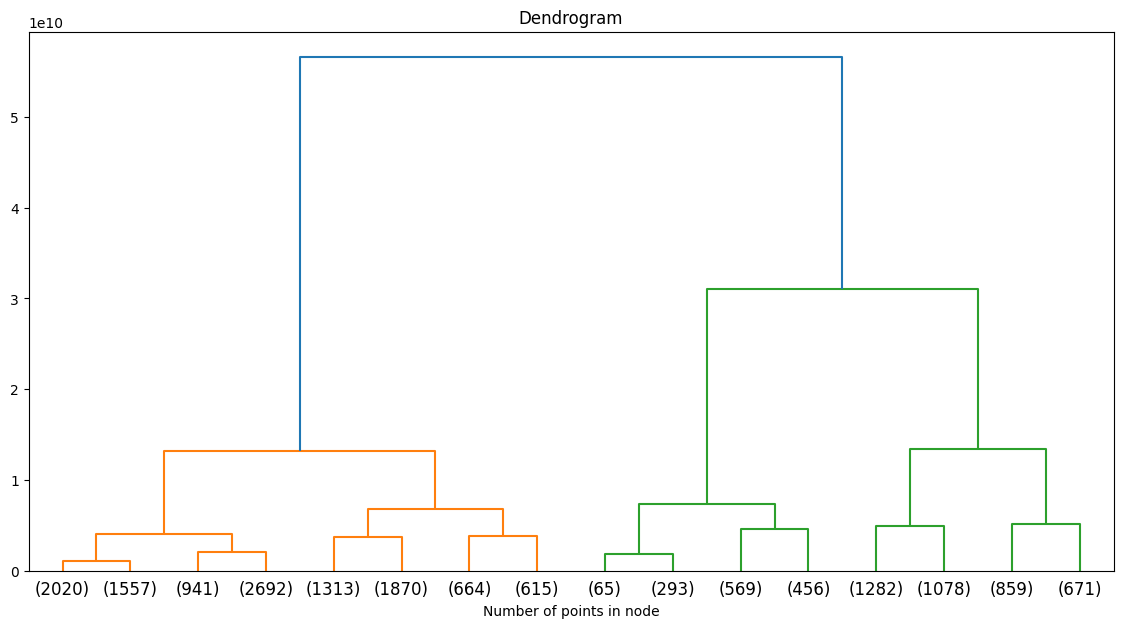

In [ ]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(14, 7))
plt.title("Dendrogram")
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

silhouette_scores = []

for n_clusters in range(2, 11):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(ready_df_imputed)
    silhouette_avg = silhouette_score(ready_df_imputed, labels)
    silhouette_scores.append(silhouette_avg)

optimal_n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # +2 because range starts from 2

In [ ]:
print(f'the optimal clustering is {optimal_n_clusters} cluster with the silhouette score:{silhouette_scores[optimal_n_clusters-2]}')

the optimal clustering is 2 cluster with the silhouette score:0.6323467468915623


In [ ]:
for i in range(len(silhouette_scores)):
  print(f'{i+2} cluster silhouette score: {silhouette_scores[i]} ')

2 cluster silhouette score: 0.6323467468915623 
3 cluster silhouette score: 0.6305265963505388 
4 cluster silhouette score: 0.5572044577223378 
5 cluster silhouette score: 0.5091658822117788 
6 cluster silhouette score: 0.4999532611880658 
7 cluster silhouette score: 0.5188669381251262 
8 cluster silhouette score: 0.5013125094027204 
9 cluster silhouette score: 0.4970069143451627 
10 cluster silhouette score: 0.49787310660507106 


In [ ]:
clustering = AgglomerativeClustering(n_clusters=2, linkage='ward', affinity='euclidean')

In [ ]:
cluster_assignment = clustering.fit_predict(ready_df_imputed)
data_cluster_agglo = pd.DataFrame(ready_df_imputed.copy())
data_cluster_agglo['Clusters'] = cluster_assignment
data_cluster_agglo.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


category  equity_style  equity_size  equity_size_score  \
1      35.0           2.0          2.0             124.69   
2      98.0           3.0          3.0             322.70   
3     129.0           1.0          3.0             229.67   
4     132.0           3.0          2.0             111.36   
7     144.0           2.0          3.0             275.85   

   price_prospective_earnings  price_book_ratio  price_sales_ratio  \
1                       23.06              1.97               1.70   
2                       27.99              3.04               2.71   
3                       17.19              1.77               0.75   
4                       12.15              1.01               0.62   
7                       16.36              1.96               1.39   

   price_cash_flow_ratio  dividend_yield_factor  \
1                  12.07                   1.30   
2                  10.35                   0.97   
3                   6.52                   2.73   
4                   3.54                   2.86   
7                  10.36                   2.44   

   long_term_projected_earnings_growth  historical_earnings_growth  \
1                                 9.34                      14.300   
2                                16.87                       6.074   
3                                 7.77                       3.170   
4                                10.02                     -14.020   
7                                 9.32                       3.460   

   sales_growth  cash_flow_growth  book_value_growth   roa    roe   roic  \
1          7.55              8.56               9.59  7.36  14.61  11.33   
2         13.80             21.53              14.76  7.83  16.35  11.62   
3          3.04             -0.32               1.86  4.68  17.51   8.65   
4        -16.23             -6.55              -2.83  1.86   7.77   2.02   
7          2.44              8.44               6.97  7.65  19.48  12.52   

   asset_stock  asset_bond  asset_cash  asset_other  sector_basic_materials  \
1        96.81        0.57        2.63        -0.01                    8.17   
2        95.92        0.00        2.21         1.87                    6.35   
3        99.98        0.00        0.21        -0.19                    3.01   
4       107.14        0.00       -7.14         0.00                   19.94   
7        34.63       53.25       11.13         0.97                    4.77   

   sector_consumer_cyclical  sector_financial_services  sector_real_estate  \
1                     14.42                      18.82               2.404   
2                     22.32                      10.82               0.440   
3                     14.47                      13.86               1.730   
4                      2.45                      16.94               1.210   
7                     11.32                      14.16               2.480   

   sector_consumer_defensive  sector_healthcare  sector_utilities  \
1                       2.96              15.34             1.590   
2                      11.74               3.37             5.862   
3                      11.37              10.43             1.390   
4                       2.83              16.24             4.000   
7                       7.46              13.52             2.580   

   sector_communication_services  sector_energy  sector_industrials  \
1                          6.064          5.746               17.32   
2                         17.140          4.540                4.39   
3                          8.460          3.270               16.32   
4                          9.420          0.960               15.72   
7                          8.100          2.070               14.84   

   sector_technology  market_cap_giant  market_cap_large  market_cap_medium  \
1              21.39              1.14              0.00              66.33   
2              23.42             62.38             21.08              11.85   
3      

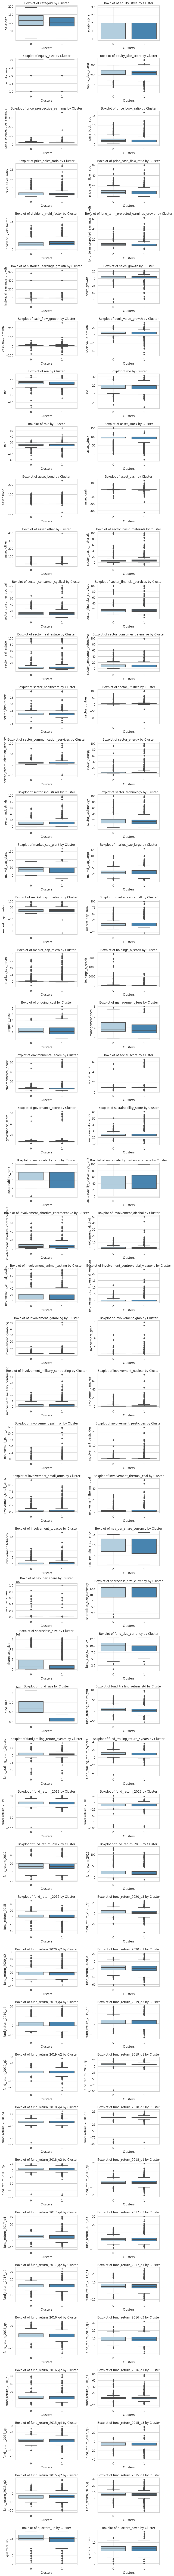

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="whitegrid")

num_features = len(data_cluster_agglo.columns[:-2])
N = int(np.ceil(num_features / 2))

# Create the subplots
fig, axes = plt.subplots(N, 2, figsize=(10, 3*N))
fig.tight_layout(pad=4.0)

for i, feature in enumerate(data_cluster_agglo.columns[:-2]):
    row, col = divmod(i, 2)
    sns.boxplot(x='Clusters', y=feature, data=data_cluster_agglo, palette="Blues", ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot of {feature} by Cluster')

if num_features % 2:
    axes[-1, -1].axis('off')

plt.show()